<a href="https://colab.research.google.com/github/Shruti022/Healthcare-Chatbot/blob/main/6998_project_evaluation_finalsubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages to install

In [ ]:
!pip install qdrant-client sentence-transformers google-generativeai pandas matplotlib seaborn openpyxl reportlab --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 143.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 229.7 MB/s eta 0:00:00


Running all agents in .py files needed to evaluate full pipeline

In [ ]:
%%writefile utils_qdrant.py
import json
import hashlib
from datetime import datetime
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer

COLLECTION_NAME = "clinical_trials"

SUPPORTED_DISEASES = [
    "diabetes", "obesity", "hypertension", "cardiovascular", "ckd",
    "alzheimer", "parkinson", "asthma", "copd",
    "breast_cancer", "lung_cancer", "prostate_cancer",
    "rheumatoid_arthritis"
]

# --- Confidence score from cosine similarity ---
# score returned by Qdrant: higher is better, max = 1.0+

def convert_similarity_to_confidence(score: float) -> float:
    """Map cosine similarity into readable clinical confidence (0-1 scale)."""
    if score is None:
        return 0.0
    # Clip values to avoid >1.0 float drift
    return max(0.0, min(1.0, score))


# --- Load Qdrant client + embedding model (updated) ---

def load_qdrant_and_model(qdrant_url: str, qdrant_api_key: str):
    """Loads Qdrant client + embedding model and verifies dataset."""

    print("⏳ Connecting to Qdrant...")
    client = QdrantClient(url=qdrant_url, api_key=qdrant_api_key)

    try:
        info = client.get_collection(COLLECTION_NAME)
        print(f"🔗 Qdrant Connected → {info.points_count:,} trials indexed")
    except Exception as e:
        raise RuntimeError(f"❌ Failed to access Qdrant collection: {e}")

    # Verify disease field exists in payload
    try:
        test_results = client.query_points(
            collection_name=COLLECTION_NAME,
            query=[0.0] * 384,
            with_payload=True,
            limit=1
        )
        sample_payload = test_results.points[0].payload

        if "disease" not in sample_payload:
            print("⚠️ WARNING: Disease field missing in payload — filtering may degrade")
        else:
            print("🧠 Disease-based retrieval enabled")

    except:
        print("⚠️ Could not verify payload fields")

    # Load matching embedding model
    embed_model = SentenceTransformer("all-MiniLM-L6-v2")
    print("🧬 Embedding model initialized")

    print(f"📌 Supported diseases: {SUPPORTED_DISEASES}")

    return client, embed_model


# --- Provenance logging (unchanged) ---

def log_provenance_step(agent_name: str, input_data, output_data, detail=None):
    """Creates a structured log entry for multi-agent tracking"""
    return {
        "timestamp": datetime.now().isoformat(),
        "agent": agent_name,
        "input": input_data,
        "output": output_data,
        "detail": detail or {},
        "model_version": "gemini-2.0-flash",  # Keep consistent with production runtime
    }


# --- Reproducibility hash (unchanged) ---

def generate_reproducibility_hash(conversation_history, corpus_version: str = "v1.0"):
    """Stable, deterministic ID for rerunning full system evaluations"""
    queries = [turn.get("query", "") for turn in conversation_history]
    raw = f"{corpus_version}|{'|'.join(queries)}"
    return hashlib.md5(raw.encode("utf-8")).hexdigest()


Overwriting utils_qdrant.py


In [ ]:
%%writefile retrieval_agent_qdrant.py
from typing import List, Dict, Any, Optional
from qdrant_client import QdrantClient

from utils_qdrant import (
    convert_similarity_to_confidence,
    log_provenance_step,
)

# ============================================================
# Disease Config for Label + Synonyms
# ============================================================

CONDITION_CONFIG: Dict[str, str] = {
    "diabetes": "Diabetes",
    "obesity": "Obesity",
    "hypertension": "Hypertension",
    "cardiovascular": "Cardiovascular Disease",
    "ckd": "Chronic Kidney Disease",
    "alzheimer": "Alzheimer’s Disease",
    "parkinson": "Parkinson’s Disease",
    "asthma": "Asthma",
    "copd": "Chronic Obstructive Pulmonary Disease",
    "breast_cancer": "Breast Cancer",
    "lung_cancer": "Lung Cancer",
    "prostate_cancer": "Prostate Cancer",
    "stroke": "Stroke",
    "rheumatoid_arthritis": "Rheumatoid Arthritis",
}

DISEASE_SYNONYMS: Dict[str, List[str]] = {
    "diabetes": ["diabetes", "t2d", "t1d", "blood sugar", "insulin", "glucose"],
    "obesity": ["obesity", "overweight", "weight loss"],
    "hypertension": ["hypertension", "high blood pressure"],
    "cardiovascular": ["cardiovascular", "heart failure", "coronary", "myocardial", "angina", "cad"],
    "ckd": ["kidney disease", "renal", "ckd"],
    "alzheimer": ["alzheimer", "dementia", "memory loss"],
    "parkinson": ["parkinson"],
    "asthma": ["asthma", "wheezing", "inhaler"],
    "copd": ["copd", "chronic obstructive", "emphysema"],
    "breast_cancer": ["breast cancer", "her2"],
    "lung_cancer": ["lung cancer", "nsclc"],
    "prostate_cancer": ["prostate cancer"],
    "stroke": ["stroke", "cva", "cerebrovascular"],
    "rheumatoid_arthritis": ["rheumatoid arthritis", "ra"],
}


# ============================================================
# Qdrant Retrieval Agent
# ============================================================

class QdrantRetrievalAgent:
    """Vector similarity + disease-aware scoring against Qdrant database"""

    def __init__(
        self,
        qdrant_client: QdrantClient,
        embed_model,
        collection_name: str = "clinical_trials",
    ):
        self.client = qdrant_client
        self.embed_model = embed_model
        self.collection_name = collection_name

    # --------------------------------------------------------
    # Detect disease from the query → soft filter
    # --------------------------------------------------------
    def detect_disease(self, query: str) -> Optional[Dict[str, str]]:
        q = query.lower()
        for key, syns in DISEASE_SYNONYMS.items():
            if any(s in q for s in syns):
                return {"key": key, "label": CONDITION_CONFIG.get(key, key)}
        return None

    # --------------------------------------------------------
    # Score disease match from payload ("disease" + "conditions")
    # --------------------------------------------------------
    def disease_match_score(self, disease_hint, payload):
        if not disease_hint:
            return 0.0

        trial_disease = (payload.get("disease") or "").lower()
        trial_conds = (payload.get("conditions") or "").lower()

        key = disease_hint["key"]
        label = disease_hint["label"].lower()

        # Strong match: exact disease field match
        if label in trial_disease:
            return 1.0

        # Secondary match: synonyms appear
        for s in DISEASE_SYNONYMS.get(key, []):
            if s in trial_conds:
                return 0.6

        return 0.0

    # --------------------------------------------------------
    # Main retrieve function
    # --------------------------------------------------------
    def retrieve(self, parsed: Dict[str, Any], top_k=5, candidate_k=30):
        query = parsed.get("query") or parsed.get("user_question") or ""
        query = query.strip()

        if not query:
            empty = {"query": "", "trials": [], "avg_confidence": 0.0}
            return empty, log_provenance_step("Qdrant", parsed, empty)

        disease_hint = self.detect_disease(query)
        q_vec = self.embed_model.encode([query])[0]

        result = self.client.query_points(
            collection_name=self.collection_name,
            query=q_vec.tolist(),
            limit=candidate_k,
            with_payload=True
        )

        trials = []
        confidences = []

        for point in result.points:
            pl = point.payload or {}

            sim = float(point.score)
            confidence = convert_similarity_to_confidence(sim)
            confidences.append(confidence)

            # Disease scoring
            disease_w = self.disease_match_score(disease_hint, pl)

            # Simple status weighting
            status = str(pl.get("status", "Unknown")).title()
            status_w = 1.0 if status == "Completed" else 0.8

            # Final relevance scoring
            relevance = (
                0.65 * sim +      # Semantic similarity
                0.25 * disease_w +  # Correct disease
                0.10 * status_w   # Study phase quality indicator
            )

            trials.append({
                "nct_id": pl.get("nct_id"),
                "title": pl.get("title"),
                "text": pl.get("text"),
                "status": status,
                "confidence": confidence,
                "relevance": relevance,
            })

        # Sort + rank
        trials.sort(key=lambda x: x["relevance"], reverse=True)
        top = trials[:top_k]

        for i, t in enumerate(top, 1):
            t["rank"] = i

        avg_conf = float(sum(confidences) / len(confidences)) if confidences else 0.0

        out = {
            "query": query,
            "disease_hint": disease_hint,
            "trials": top,
            "avg_confidence": avg_conf,
        }

        log = log_provenance_step("QdrantRetrievalAgent", parsed, out)
        return out, log


Overwriting retrieval_agent_qdrant.py


In [ ]:
%%writefile run_bot_qdrant.py

"""
Updated HealthcareBot using Qdrant instead of FAISS
- Uses QdrantRetrievalAgent for vector search
- Shows rich greeting (G2) ONLY when no clear supported disease is detected
"""

import json
import re
from typing import List, Dict, Any
import numpy as np
import requests
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold

# Import utilities
from utils_qdrant import (
    load_qdrant_and_model,
    log_provenance_step,
    generate_reproducibility_hash,
)

# Qdrant-based retrieval agent
from retrieval_agent_qdrant import QdrantRetrievalAgent

# Optional (not used directly here, kept for future reranking)
CrossEncoder = None
try:
    from sentence_transformers import CrossEncoder  # noqa: F401
except Exception:
    pass


# ============================================================
# PARSER
# ============================================================
class SymptomParser:
    def __init__(self, model):
        self.model = model

    def parse(self, text: str):
        """
        Enhanced parser for clinical trial search queries.
        Decides:
        - Are they searching for trials or just asking a question?
        - Which disease is implied (if any)?
        """
        prompt = (
            "You are a clinical trial search classifier for medical research.\n"
            "You support conditions including: diabetes, obesity, hypertension, "
            "cardiovascular disease, chronic kidney disease (CKD), Alzheimer's disease, "
            "Parkinson's disease, asthma, COPD, breast cancer, lung cancer, "
            "prostate cancer, stroke, and rheumatoid arthritis.\n\n"
            f"User Input: \"{text}\"\n\n"
            "Your tasks:\n"
            "1) Decide if the user is searching for clinical trials or just asking a general question.\n"
            "2) Detect which disease(s) they are talking about.\n"
            "3) Detect if the query is not about health or clinical trials (off_topic).\n\n"
            "Classification Rules:\n"
            "- If the query mentions or implies trials, studies, research, clinical experiments, etc. → intent='trial_search'\n"
            "- If the user is mainly describing themselves (age, diagnosis, comorbidities, meds) → intent='profile_info'\n"
            "- If they ask 'what is X', 'how does Y work', etc. without asking about trials → intent='general_question'\n"
            "- Simple greetings (hi, hello, hey) → intent='greeting'\n"
            "- If clearly not about health or clinical research → intent='off_topic', is_disease_related=false\n\n"
            "You must detect disease_focus whenever possible.\n\n"
            "Return ONLY valid JSON with this exact format:\n"
            "{\n"
            "  \"intent\": \"trial_search\" | \"profile_info\" | \"general_question\" | \"greeting\" | \"off_topic\",\n"
            "  \"query_type\": \"trial_query\" | \"profile_statement\" | \"knowledge_seeking\" | \"greeting\",\n"
            "  \"search_keywords\": [\"keyword1\", \"keyword2\"],\n"
            "  \"is_disease_related\": true or false,\n"
            "  \"disease_focus\": [\"diabetes\", \"obesity\", \"hypertension\", \"cardiovascular\", \"ckd\",\n"
            "                     \"alzheimer\", \"parkinson\", \"asthma\", \"copd\",\n"
            "                     \"breast_cancer\", \"lung_cancer\", \"prostate_cancer\",\n"
            "                     \"stroke\", \"rheumatoid_arthritis\"],\n"
            "  \"user_question\": \"the question in plain English\",\n"
            "  \"trial_interest\": \"what type of trial they want (diet, medication, technology, surgery, etc.)\"\n"
            "}\n"
        )

        try:
            res = self.model.generate_content(prompt)
            raw = (res.text or "").strip()
            match = re.search(r"\{.*\}", raw, re.DOTALL)
            if match:
                parsed = json.loads(match.group(0))
            else:
                parsed = json.loads(raw)
        except Exception:
            # Fallback: simple heuristic if model fails
            text_lower = text.lower()
            disease_focus = []

            def has_any(words):
                return any(w in text_lower for w in words)

            if has_any(["diabetes", "insulin", "glucose", "hba1c", "metformin", "glp-1", "sglt2"]):
                disease_focus.append("diabetes")
            if has_any(["obesity", "overweight", "weight loss"]):
                disease_focus.append("obesity")
            if has_any(["hypertension", "high blood pressure"]):
                disease_focus.append("hypertension")
            if has_any(["heart failure", "cardiovascular", "angina", "coronary", "myocardial", "stroke"]):
                disease_focus.append("cardiovascular")
            if has_any(["chronic kidney", "ckd", "renal failure", "kidney disease"]):
                disease_focus.append("ckd")
            if has_any(["alzheimer", "alzheimers", "dementia", "memory loss", "cognitive decline"]):
                disease_focus.append("alzheimer")
            if has_any(["parkinson", "parkinson's"]):
                disease_focus.append("parkinson")
            if has_any(["asthma", "wheezing"]):
                disease_focus.append("asthma")
            if has_any(["copd", "chronic obstructive", "emphysema", "chronic bronchitis"]):
                disease_focus.append("copd")
            if has_any(["breast cancer"]):
                disease_focus.append("breast_cancer")
            if has_any(["lung cancer", "nsclc", "small cell lung cancer"]):
                disease_focus.append("lung_cancer")
            if has_any(["prostate cancer"]):
                disease_focus.append("prostate_cancer")
            if has_any(["stroke", "cerebrovascular accident", "cva"]):
                disease_focus.append("stroke")
            if has_any(["rheumatoid arthritis", "ra", "inflammatory arthritis"]):
                disease_focus.append("rheumatoid_arthritis")

            if has_any(["trial", "study", "studies", "research", "clinical"]):
                intent = "trial_search"
                query_type = "trial_query"
            elif has_any(["hi", "hello", "hey"]):
                intent = "greeting"
                query_type = "greeting"
            else:
                intent = "general_question"
                query_type = "knowledge_seeking"

            parsed = {
                "intent": intent,
                "query_type": query_type,
                "search_keywords": [text] if intent == "trial_search" else [],
                "is_disease_related": bool(disease_focus),
                "disease_focus": disease_focus,
                "user_question": text,
                "trial_interest": "general",
            }

        # --- Heuristic correction layer on top of model output ---
        text_lower = text.lower()
        diseases = set(parsed.get("disease_focus") or [])

        def maybe_add(words, label):
            if any(w in text_lower for w in words):
                diseases.add(label)

        maybe_add(["diabetes", "insulin", "glucose", "hba1c", "metformin", "glp-1", "sglt2"], "diabetes")
        maybe_add(["obesity", "overweight", "weight loss"], "obesity")
        maybe_add(["hypertension", "high blood pressure"], "hypertension")
        maybe_add(["heart failure", "cardiovascular", "angina", "coronary", "myocardial", "stroke"], "cardiovascular")
        maybe_add(["chronic kidney", "ckd", "renal failure", "kidney disease"], "ckd")
        maybe_add(["alzheimer", "alzheimers", "dementia", "memory loss", "cognitive decline"], "alzheimer")
        maybe_add(["parkinson", "parkinson's"], "parkinson")
        maybe_add(["asthma", "wheezing", "inhaler"], "asthma")
        maybe_add(["copd", "chronic obstructive", "emphysema", "chronic bronchitis"], "copd")
        maybe_add(["breast cancer"], "breast_cancer")
        maybe_add(["lung cancer", "nsclc", "small cell lung cancer"], "lung_cancer")
        maybe_add(["prostate cancer"], "prostate_cancer")
        maybe_add(["stroke", "cerebrovascular accident", "cva"], "stroke")
        maybe_add(["rheumatoid arthritis", "inflammatory arthritis", "ra"], "rheumatoid_arthritis")

        parsed["disease_focus"] = list(diseases)

        # Force trial_search if obvious trial keywords
        trial_keywords = [
            "trial", "study", "studies", "research",
            "clinical", "show me", "are there", "what trials",
        ]
        if any(kw in text_lower for kw in trial_keywords):
            parsed["intent"] = "trial_search"
            parsed["query_type"] = "trial_query"

        # If we detected diseases, ensure is_disease_related = True
        if diseases and parsed.get("intent") != "off_topic":
            parsed["is_disease_related"] = True
        elif "is_disease_related" not in parsed:
            parsed["is_disease_related"] = bool(diseases)

        log = log_provenance_step("SymptomParser", text, parsed)
        return parsed, log


# ============================================================
# PROFILE AGENT
# ============================================================
class ProfileAgent:
    def __init__(self, initial_profile: Dict[str, Any] = None):
        if initial_profile is None:
            initial_profile = {
                "user_id": "Patient",
                "conditions": [],
                "extracted_conditions": [],
                "history": [],
            }
        self.profile = initial_profile

    def update_profile(self, turn_data: Dict[str, Any]):
        self.profile.setdefault("history", []).append(turn_data)
        self.profile.setdefault("extracted_conditions", [])

        parsed = turn_data.get("parsed", {})
        diseases = parsed.get("disease_focus") or []
        if diseases:
            current = set(self.profile["extracted_conditions"])
            for d in diseases:
                current.add(d)
            self.profile["extracted_conditions"] = list(current)

        snapshot = {
            "user_id": self.profile.get("user_id", "Patient"),
            "known_conditions": self.profile.get("extracted_conditions", []),
            "num_turns": len(self.profile["history"]),
        }
        log = log_provenance_step("ProfileAgent", turn_data, {"profile_snapshot": snapshot})
        return log


# ============================================================
# EVIDENCE-WEIGHTED SCORER (still used downstream)
# ============================================================
class EvidenceWeightedScorer:
    def __init__(self):
        self.status_weights = {
            "Completed": 1.0,
            "Active, Not Recruiting": 0.9,
            "Recruiting": 0.85,
            "Enrolling By Invitation": 0.8,
            "Not Yet Recruiting": 0.6,
            "Terminated": 0.4,
            "Withdrawn": 0.3,
            "Suspended": 0.3,
            "Unknown Status": 0.5,
        }

        self.design_keywords = {
            "randomized controlled": 1.0,
            "double-blind": 0.95,
            "randomized": 0.9,
            "controlled": 0.85,
            "interventional": 0.8,
            "prospective": 0.75,
            "observational": 0.6,
            "retrospective": 0.5,
        }

    def calculate_weighted_score(
        self,
        trial: Dict[str, Any],
        base_confidence: float,
        query: str,
    ) -> Dict[str, Any]:
        match_score = base_confidence * 0.35

        status = str(trial.get("status", "Unknown Status")).strip().title()
        status_score = self.status_weights.get(status, 0.5) * 0.25

        design_score = self._calculate_design_quality(trial) * 0.20
        keyword_score = self._calculate_keyword_density(trial, query) * 0.10
        completeness_score = self._calculate_completeness(trial) * 0.10

        weighted_score = (
            match_score +
            status_score +
            design_score +
            keyword_score +
            completeness_score
        )

        breakdown = {
            "base_confidence": base_confidence,
            "weighted_score": weighted_score,
            "factors": {
                "semantic_match": match_score,
                "trial_status": status_score,
                "study_design": design_score,
                "keyword_density": keyword_score,
                "completeness": completeness_score,
            },
        }

        return {
            "weighted_score": min(weighted_score, 1.0),
            "breakdown": breakdown,
        }

    def _calculate_design_quality(self, trial: Dict[str, Any]) -> float:
        text = f"{trial.get('title', '')} {trial.get('text', '')}".lower()
        max_score = 0.0
        for keyword, weight in self.design_keywords.items():
            if keyword in text:
                max_score = max(max_score, weight)
        return max_score if max_score > 0 else 0.6

    def _calculate_keyword_density(self, trial: Dict[str, Any], query: str) -> float:
        text = f"{trial.get('title', '')} {trial.get('text', '')}".lower()
        stopwords = {
            "the", "a", "an", "and", "or", "for", "with", "in", "on", "at", "to",
            "of", "is", "are", "what", "trials", "trial", "study", "studies", "clinical",
        }
        query_terms = [
            term for term in query.lower().split()
            if term not in stopwords and len(term) > 2
        ]
        if not query_terms:
            return 0.5
        matches = sum(1 for term in query_terms if term in text)
        density = matches / len(query_terms)
        return min(density, 1.0)

    def _calculate_completeness(self, trial: Dict[str, Any]) -> float:
        text = trial.get("text", "") or ""
        title = trial.get("title", "") or ""
        score = 0.0
        if len(title) > 10:
            score += 0.3
        if len(text) > 200:
            score += 0.7
        return min(score, 1.0)


# ============================================================
# PubMed Helper (NCT → PubMed abstract)
# ============================================================
def fetch_pubmed_abstract_for_nct(nct_id: str):
    try:
        esearch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
        params = {
            "db": "pubmed",
            "term": f"{nct_id}[si]",
            "retmode": "json",
            "retmax": 1,
        }
        r = requests.get(esearch_url, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()
        idlist = data.get("esearchresult", {}).get("idlist", [])
        if not idlist:
            return None

        pmid = idlist[0]

        efetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
        params = {
            "db": "pubmed",
            "id": pmid,
            "rettype": "abstract",
            "retmode": "text",
        }
        r2 = requests.get(efetch_url, params=params, timeout=10)
        r2.raise_for_status()
        abstract_text = r2.text.strip()
        if not abstract_text:
            return None

        return {"pmid": pmid, "abstract": abstract_text}
    except Exception:
        return None


# ============================================================
# DIAGNOSIS / ADVISOR
# ============================================================
class DiagnosisAdvisor:
    def __init__(self, model):
        self.model = model

    def _handle_general_question(self, parsed: Dict[str, Any], retrieved: Dict[str, Any]):
        trials = retrieved.get("trials", [])
        user_question = parsed.get("user_question") or " ".join(parsed.get("symptoms", []))

        evidence_parts = []
        for t in trials[:3]:
            evidence_parts.append(f"Trial {t['nct_id']}: {t['text'][:400]}")
        evidence = "\n\n".join(evidence_parts) if evidence_parts else "No specific trials available."

        prompt = (
            "You are a medical research educator. Answer the user's question clearly using reliable medical knowledge.\n"
            "The clinical trial evidence below provides real-world context - mention it if helpful.\n\n"
            f"USER'S QUESTION: {user_question}\n\n"
            "CLINICAL TRIAL CONTEXT (for reference only):\n"
            f"{evidence}\n\n"
            "Instructions:\n"
            "- Answer the question directly in 3–5 sentences.\n"
            "- Be specific and educational.\n"
            "- Do NOT give diagnoses or treatment instructions.\n"
            "- End with: 'For personalized advice, please consult your healthcare provider.'\n"
        )

        try:
            res = self.model.generate_content(prompt)
            text = (res.text or "").strip()
            if not text or len(text) < 50:
                text = (
                    "I don't have enough information to answer this question accurately. "
                    "For personalized guidance, please consult your healthcare provider."
                )
            return text
        except Exception:
            return (
                "I'm unable to generate a detailed answer right now. "
                "For personalized guidance, please consult your healthcare provider."
            )

    def _handle_symptom_query(
        self,
        parsed: Dict[str, Any],
        retrieved: Dict[str, Any],
        profile: Dict[str, Any],
    ):
        trials = retrieved.get("trials", [])
        if not trials:
            return "No relevant trials were found. Please try refining your query."

        formatted_trials = []
        for t in trials[:5]:
            title = t.get("title", "") or t["text"].split("\n")[0].replace("Title: ", "")
            status = t.get("status", "Unknown")
            weighted_score = t.get("weighted_score", t.get("relevance", 0.0))

            raw_text = t.get("text", "")
            brief_summary = raw_text.split("Summary:", 1)[-1].strip() if "Summary:" in raw_text else raw_text

            if brief_summary:
                prompt = (
                    "Rewrite the following clinical trial description as a short, clear paragraph "
                    "about what the study is testing:\n\n"
                    f"{brief_summary}\n\n"
                    "Guidelines:\n"
                    "- Use 2–4 sentences.\n"
                    "- Plain English, minimal jargon.\n"
                    "- Include the purpose and the main type of participant.\n"
                )
                try:
                    res = self.model.generate_content(prompt)
                    brief_summary = res.text.strip() if res.text else brief_summary
                except Exception:
                    if len(brief_summary) > 600:
                        brief_summary = brief_summary[:600] + "..."
            else:
                brief_summary = "No summary available."

            pubmed_block = ""
            pub = fetch_pubmed_abstract_for_nct(t["nct_id"])
            if pub:
                abs_text = pub["abstract"]
                max_len = 2000
                if len(abs_text) > max_len:
                    abs_text = abs_text[:max_len] + "..."
                pubmed_block = (
                    f"  PubMed abstract (PMID {pub['pmid']}):\n"
                    f"  {abs_text}\n\n"
                    f"  PubMed link: https://pubmed.ncbi.nlm.nih.gov/{pub['pmid']}/\n\n"
                )

            formatted_trials.append(
                f"**{t['nct_id']}** (Relevance: {weighted_score:.0%})\n"
                f"• {title}\n"
                f"  Status: {status}\n\n"
                f"  {brief_summary}\n\n"
                f"{pubmed_block}"
            )

        trials_text = "\n\n".join(formatted_trials)
        num_trials = len(formatted_trials)

        response = (
            f"I found {num_trials} clinical trial{'s' if num_trials != 1 else ''} relevant to your request:\n\n"
            f"{trials_text}\n\n"
            "Summary: These trials explore potential treatments or management strategies for the condition you asked about. "
            "More details are available using the listed NCT IDs.\n\n"
            "To learn more or consider participation, visit clinicaltrials.gov and search by NCT ID. "
            "Always discuss clinical trial options with your healthcare provider."
        )

        return response

    def advise(self, parsed: Dict[str, Any], retrieved: Dict[str, Any], profile: Dict[str, Any]):
        trials = retrieved.get("trials", [])
        avg_conf = retrieved.get("avg_confidence", 0.0)
        query_type = parsed.get("query_type", "trial_query")
        is_disease_related = parsed.get("is_disease_related", True)

        draft = {
            "recommendation": "",
            "avg_confidence": avg_conf,
            "query_type": query_type,
        }

        if not is_disease_related:
            draft["recommendation"] = (
                "I’m specialized in clinical trials for medical conditions such as:\n"
                "- Diabetes\n"
                "- Obesity\n"
                "- Hypertension & cardiovascular disease\n"
                "- Chronic kidney disease (CKD)\n"
                "- Alzheimer’s & Parkinson’s disease\n"
                "- Asthma & COPD\n"
                "- Breast, lung, and prostate cancer\n"
                "- Stroke\n"
                "- Rheumatoid arthritis\n\n"
                "Your question does not appear to be about a health condition or clinical research. "
                "If you’d like, you can ask me about trials for one of these conditions."
            )
            draft["confidence_veto"] = True
            log = log_provenance_step(
                "DiagnosisAdvisor",
                parsed,
                draft,
                {"veto": True, "reason": "off_topic"},
            )
            return draft, log

        if not trials or avg_conf < 0.05:
            draft["recommendation"] = (
                "Based on the trials I retrieved, I don’t have strong enough evidence to answer this question directly. "
                "Please consult your healthcare provider for personalized advice."
            )
            draft["confidence_veto"] = True
            log = log_provenance_step(
                "DiagnosisAdvisor",
                parsed,
                draft,
                {"veto": True, "reason": "low_confidence"},
            )
            return draft, log

        if query_type == "knowledge_seeking":
            draft["recommendation"] = self._handle_general_question(parsed, retrieved)
        else:
            draft["recommendation"] = self._handle_symptom_query(parsed, retrieved, profile)

        draft["confidence_veto"] = False
        log = log_provenance_step("DiagnosisAdvisor", parsed, draft)
        return draft, log


# ============================================================
# SAFETY FILTER
# ============================================================
# class ActiveSafetyFilter:
#     def __init__(self, model):
#         self.model = model
#         self.safety_cfg = {
#             HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
#         }

#     def verify(self, advice_text: str, trials: List[Dict[str, Any]]):
#         # Skip safety check for straightforward trial listings
#         if any(marker in advice_text for marker in ["NCT", "clinical trial", "clinicaltrials.gov"]):
#             log = log_provenance_step(
#                 "ActiveSafetyFilter",
#                 {"advice": advice_text},
#                 {"final_text": advice_text, "status": "Pass (Trial Listing)"},
#             )
#             return advice_text, "Pass (Trial Listing)", log

#         evidence_text = "\n".join(t["text"][:500] for t in trials[:3])

#         audit_prompt = (
#             "You are a Medical Safety Officer reviewing AI-generated advice.\n\n"
#             "ADVICE:\n"
#             f"{advice_text}\n\n"
#             "EVIDENCE FROM CLINICAL TRIALS (for context):\n"
#             f"{evidence_text}\n\n"
#             "Check for safety issues:\n"
#             "- If the advice suggests starting/stopping/changing medication without a doctor → UNSAFE.\n"
#             "- If it gives a diagnosis → UNSAFE.\n"
#             "- If it makes strong clinical claims not supported by evidence → UNSAFE.\n"
#             "- If it simply lists clinical trials with neutral wording and a recommendation to talk to a doctor → SAFE.\n\n"
#             "If the advice is acceptable, respond with exactly: SAFE\n"
#             "If it is not acceptable, respond starting with: CORRECTED: <safer version>\n"
#         )

#         try:
#             res = self.model.generate_content(audit_prompt, safety_settings=self.safety_cfg)
#             txt = (res.text or "").strip()
#             if txt.startswith("SAFE") or "SAFE" in txt:
#                 final_text = advice_text
#                 status = "Pass"
#             else:
#                 final_text = f"⚠️ SAFETY REVISION:\n{txt}"
#                 status = "Revised"
#         except Exception:
#             if "NCT" in advice_text or "clinical trial" in advice_text.lower():
#                 final_text = advice_text
#                 status = "Pass (API Fallback)"
#             else:
#                 final_text = "⚠️ Safety filter triggered. Please consult a doctor."
#                 status = "Revised (API Error)"

#         log = log_provenance_step(
#             "ActiveSafetyFilter",
#             {"advice": advice_text},
#             {"final_text": final_text, "status": status},
#         )
#         return final_text, status, log



# ============================================================
# SAFETY FILTER
# ============================================================

class ActiveSafetyFilter:
    def __init__(self, model):
        self.model = model
        self.safety_cfg = {
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        }

    def _looks_like_medical_advice(self, text: str) -> bool:
        t = text.lower()
        risky_phrases = [
            "you should stop",
            "stop taking",
            "change your dose",
            "change your medication",
            "start taking",
            "take this drug",
            "take this medicine",
            "this is the best treatment for you",
            "i recommend you",
            "i recommend that you",
            "instead of your current medicine",
            "instead of your current medication",
            "it is safe to stop",
            "you can discontinue",
            "you can safely stop",
            "your diagnosis is",
            "the diagnosis is",
            "you have ",
        ]
        return any(p in t for p in risky_phrases)

    def verify(self, advice_text: str, trials: List[Dict[str, Any]]):
        # 0) Always allow pure trial listings
        if any(
            marker in advice_text
            for marker in ["NCT", "clinical trial", "clinicaltrials.gov"]
        ):
            log = log_provenance_step(
                "ActiveSafetyFilter",
                {"advice": advice_text},
                {"final_text": advice_text, "status": "Pass (Trial Listing)"},
            )
            return advice_text, "Pass (Trial Listing)", log

        # 1) Hard keyword veto for obvious medical advice
        if self._looks_like_medical_advice(advice_text):
            safer = (
                "⚠️ I cannot provide specific medical instructions such as starting, "
                "stopping, or changing medications or doses. Please discuss treatment "
                "decisions with your healthcare provider. I can help you explore "
                "relevant clinical trials and explain their general purpose instead."
            )
            log = log_provenance_step(
                "ActiveSafetyFilter",
                {"advice": advice_text},
                {"final_text": safer, "status": "Revised (Keyword Safety Gate)"},
            )
            return safer, "Revised (Keyword Safety Gate)", log

        # 2) Use LLM audit as a secondary check
        evidence_text = "\n".join(t["text"][:500] for t in trials[:3])

        audit_prompt = (
            "You are a Medical Safety Officer reviewing AI-generated advice.\n\n"
            "ADVICE:\n"
            f"{advice_text}\n\n"
            "EVIDENCE FROM CLINICAL TRIALS (for context):\n"
            f"{evidence_text}\n\n"
            "Mark advice as UNSAFE if it does ANY of the following:\n"
            "- Suggests starting, stopping, or changing any medication or dose.\n"
            "- Provides a diagnosis (for example, 'you have X', 'this means you have Y').\n"
            "- Recommends a specific treatment, drug, or trial as best for this user.\n"
            "- Discourages consulting a healthcare professional.\n"
            "- Makes strong clinical claims that are not clearly supported by evidence.\n\n"
            "If the advice is acceptable, respond with exactly: SAFE\n"
            "If it is not acceptable, respond starting with: CORRECTED: <safer version>\n"
        )

        try:
            res = self.model.generate_content(
                audit_prompt, safety_settings=self.safety_cfg
            )
            txt = (res.text or "").strip()
            if txt.startswith("SAFE") or "SAFE" == txt:
                final_text = advice_text
                status = "Pass"
            else:
                final_text = f"⚠️ SAFETY REVISION:\n{txt}"
                status = "Revised"
        except Exception:
            if "NCT" in advice_text or "clinical trial" in advice_text.lower():
                final_text = advice_text
                status = "Pass (API Fallback)"
            else:
                final_text = (
                    "⚠️ Safety filter triggered. Please consult your healthcare provider "
                    "for personalized medical advice."
                )
                status = "Revised (API Error)"

        log = log_provenance_step(
            "ActiveSafetyFilter",
            {"advice": advice_text},
            {"final_text": final_text, "status": status},
        )
        return final_text, status, log


# ============================================================
# HEALTHCAREBOT - Updated to use Qdrant + G2 / B3 behavior
# ============================================================

class HealthcareBot:
    def __init__(self, qdrant_client, embed_model, gemini_model, initial_profile=None):
        self.parser = SymptomParser(gemini_model)
        self.profile_agent = ProfileAgent(initial_profile)
        self.evidence_scorer = EvidenceWeightedScorer()

        # Qdrant-based retrieval agent
        self.retrieval = QdrantRetrievalAgent(
            qdrant_client=qdrant_client,
            embed_model=embed_model,
            collection_name="clinical_trials",
        )

        self.advisor = DiagnosisAdvisor(gemini_model)
        self.safety_filter = ActiveSafetyFilter(gemini_model)
        self.conversation_history: List[Dict[str, Any]] = []
        self.provenance_log: List[Dict[str, Any]] = []

    # -------------- Greeting builder (G2 style) --------------
    def _build_greeting(self) -> str:
        return (
            "👋 Hi, I’m your clinical trial assistant.\n\n"
            "I can search **real clinical trials** for:\n"
            "- Diabetes (type 1 & type 2)\n"
            "- Obesity & weight management\n"
            "- Hypertension & cardiovascular disease\n"
            "- Chronic kidney disease (CKD)\n"
            "- Alzheimer’s disease\n"
            "- Parkinson’s disease\n"
            "- Asthma\n"
            "- COPD (chronic obstructive pulmonary disease)\n"
            "- Breast, lung, and prostate cancer\n"
            "- Stroke\n"
            "- Rheumatoid arthritis\n\n"
            "**Try asking:**\n"
            "• \"GLP-1 agonist trials for type 2 diabetes\"\n"
            "• \"Weight loss studies for obesity\"\n"
            "• \"Breast cancer immunotherapy clinical trials\"\n"
            "• \"New asthma biologic trials for adults\"\n"
            "• \"Recent rheumatoid arthritis treatment studies\"\n\n"
            "Tell me your condition and what kind of trial you’re interested in (medication, diet, devices, etc.), "
            "and I’ll surface the most relevant studies."
        )

    def chat(self, user_input: str) -> Dict[str, Any]:
        """Process user input through the pipeline."""

        # 1) Parse intent
        parsed, parse_log = self.parser.parse(user_input)
        self.provenance_log.append(parse_log)

        intent = parsed.get("intent", "")
        disease_focus = parsed.get("disease_focus") or []
        is_disease_related = parsed.get("is_disease_related", True)

        # 2) G2 + B3 behavior:
        #    If clear disease → go straight to retrieval.
        #    If greeting / off-topic / no disease → show greeting instead.
        if intent == "greeting" or not disease_focus or not is_disease_related:
            greeting = self._build_greeting()

            full_turn = {
                "query": user_input,
                "parsed": parsed,
                "retrieved": {"query": "", "trials": [], "avg_confidence": 0.0},
                "response": greeting,
                "timestamp": parse_log["timestamp"],
            }
            self.conversation_history.append(full_turn)

            return {
                "response": greeting,
                "avg_confidence": 0.0,
                "num_trials": 0,
                "provenance": self.provenance_log[-5:],
                "session_hash": generate_reproducibility_hash(self.conversation_history),
            }

        # 3) Update profile for disease-related / trial queries
        turn_data = {"query": user_input, "parsed": parsed}
        profile_log = self.profile_agent.update_profile(turn_data)
        self.provenance_log.append(profile_log)

        # 4) Retrieve trials from Qdrant
        retrieved, retrieval_log = self.retrieval.retrieve(parsed, top_k=5)
        self.provenance_log.append(retrieval_log)

        # 5) Generate advisory response
        profile_snapshot = {
            "user_id": self.profile_agent.profile.get("user_id", "Patient"),
            "known_conditions": self.profile_agent.profile.get("extracted_conditions", []),
        }

        draft, advisor_log = self.advisor.advise(parsed, retrieved, profile_snapshot)
        self.provenance_log.append(advisor_log)

        # 6) Safety filter
        advice_text = draft.get("recommendation", "") if isinstance(draft, dict) else str(draft)
        trials = retrieved.get("trials", [])

        final_response, safety_status, safety_log = self.safety_filter.verify(advice_text, trials)
        self.provenance_log.append(safety_log)

        # 7) Save turn
        full_turn = {
            "query": user_input,
            "parsed": parsed,
            "retrieved": retrieved,
            "response": final_response,
            "timestamp": parse_log["timestamp"],
            "safety_status": safety_status,
        }
        self.conversation_history.append(full_turn)

        return {
            "response": final_response,
            "avg_confidence": retrieved.get("avg_confidence", 0.0),
            "num_trials": len(retrieved.get("trials", [])),
            "provenance": self.provenance_log[-5:],
            "session_hash": generate_reproducibility_hash(self.conversation_history),
            "safety_status": safety_status,
        }


def run_bot(user_input: str, qdrant_client, embed_model, gemini_model) -> Dict[str, Any]:
    """Convenience wrapper for single queries."""
    bot = HealthcareBot(qdrant_client, embed_model, gemini_model)
    return bot.chat(user_input)


First evalution for "hard" queries using full HealthcareBot pipeline across metrics:

* top1_correct: if first retrieved trial classified under correct disease
category (retrieval position and address ambiguity or robust query) 1 perfect match else 0
* recall_at_5: did pipeline retrieve at least 1 correct disease within 5 results (1 if any else 0)
* ndcg_at_5: how well results sorted in order of relevance (1 perfect sorting else 0 if nothing relevant) comparison to ideal best possible ranking; most relevant trials appear at higher ranks than a high ndcg
* map_at_5: how many relevant trials retrieved and how well ranked they are checking if multiple correct items retrieved and how quick 1 if all relevant trials quickly appear vs low values if not many relevant or poorly ranked results in output
* num_trials: how many trials Qdrant return prior to summarization if low retrieval is failing and coverage is poor
* avg_confidence: average similarity score across returned top results (from hybrid scoring semantic and rule based disease score)


In [ ]:
# ================================================
# 0. Setup & Imports
# ================================================
import os
import math
import json
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from qdrant_client import QdrantClient
from utils_qdrant import (
    load_qdrant_and_model,
    COLLECTION_NAME,
    SUPPORTED_DISEASES,
)

print("Supported diseases in index:", SUPPORTED_DISEASES)


Supported diseases in index: ['diabetes', 'obesity', 'hypertension', 'cardiovascular', 'ckd', 'alzheimer', 'parkinson', 'asthma', 'copd', 'breast_cancer', 'lung_cancer', 'prostate_cancer', 'rheumatoid_arthritis']


In [ ]:
# ================================================
# 1. Connect to Qdrant & Load Embedding Model
#    (reuses your existing project utilities)
# ================================================

import getpass

# --- Keys ---
QDRANT_API_KEY = getpass.getpass("Qdrant API Key: ")
QDRANT_URL = "https://215ec69e-fa22-4f38-bcf3-941e73901a68.us-east4-0.gcp.cloud.qdrant.io"
qdrant_client, embed_model = load_qdrant_and_model(QDRANT_URL, QDRANT_API_KEY)


Qdrant API Key: ··········
⏳ Connecting to Qdrant...
🔗 Qdrant Connected → 112,987 trials indexed
🧠 Disease-based retrieval enabled
🧬 Embedding model initialized
📌 Supported diseases: ['diabetes', 'obesity', 'hypertension', 'cardiovascular', 'ckd', 'alzheimer', 'parkinson', 'asthma', 'copd', 'breast_cancer', 'lung_cancer', 'prostate_cancer', 'rheumatoid_arthritis']


In [ ]:
# ================================================
# 2. Define Challenging / Adversarial Queries
#    - Ambiguity
#    - Misspellings
#    - Comorbidities
#    - Age / population constraints
#    - Modality-specific, niche
# ================================================

# 14-disease set you are using:
DISEASES = [
    "diabetes",
    "obesity",
    "hypertension",
    "cardiovascular",
    "ckd",
    "alzheimer",
    "parkinson",
    "asthma",
    "copd",
    "breast_cancer",
    "lung_cancer",
    "prostate_cancer",
    "stroke",
    "rheumatoid_arthritis",
]

# Hard queries: intentionally “messy” and not textbook
HARD_QUERIES = {
    "diabetes": [
        "older adult on statins with slowly rising sugar and belly fat – any trials to prevent full-blown diabetes?",
        "clinical studies where they try to get people OFF insulin rather than just add more meds",
        "trials looking at sleep or circadian rhythm to improve glucose in pre-diabetic night-shift workers",
        "research on people with both fatty liver and borderline A1c, not yet called ‘diabetic’",
        "studies where GLP-1s are combined with diet coaching for long-standing ‘brittle’ diabetes",
    ],
    "obesity": [
        "weight-loss trials that AREN’T surgery or GLP-1 injections for someone who yo-yo diets constantly",
        "programs that test app-based coaching plus meds for people who regain weight after bariatric surgery",
        "trials that care more about muscle preservation than just weight on the scale",
        "research on young adults with ‘normal’ BMI but high visceral fat and metabolic syndrome",
        "are there intensive lifestyle intervention studies for folks who already failed commercial diet programs?",
    ],
    "hypertension": [
        "studies that look at blood pressure spikes under stress rather than clinic values only",
        "clinical trials for high blood pressure in people who can’t tolerate ACE inhibitors",
        "research combining home BP monitoring with telehealth coaching instead of just adding more pills",
        "trials for patients whose BP is fine at home but always high in the office (‘white coat’ issue)",
        "are there studies that focus on salt sensitivity and genetic predisposition to hypertension?",
    ],
    "cardiovascular": [
        "trials for people who have coronary calcium on CT but no prior heart attack yet",
        "research on aggressive LDL lowering in middle-aged folks with strong family history but normal tests",
        "studies that look at GLP-1 or SGLT2 for cardioprotection in overweight people without diabetes",
        "clinical trials that follow long COVID patients for heart inflammation or arrhythmias",
        "are there prevention trials mixing exercise, statins, and anti-inflammatory drugs for heart risk?",
    ],
    "ckd": [
        "kidney protection trials in people with only a tiny drop in eGFR but lots of albumin in urine",
        "studies that test SGLT2 inhibitors mainly for kidney outcomes not just diabetes control",
        "research for patients with both hypertension and early CKD who already tried ACE/ARB",
        "clinical trials about slowing cyst growth in inherited kidney disease rather than just dialysis outcomes",
        "trials looking at diet + low-protein strategies to delay dialysis in stage 3 CKD",
    ],
    "alzheimer": [
        "are there trials for people who only have amyloid PET changes but no memory symptoms yet?",
        "studies pairing digital cognitive training apps with new anti-amyloid antibodies",
        "research combining sleep apnea treatment and dementia prevention in high-risk groups",
        "trials where caregivers are part of the intervention, not just the patient with memory decline",
        "clinical studies that measure tau PET and subtle executive dysfunction before full Alzheimer diagnosis",
    ],
    "parkinson": [
        "early Parkinson’s trials where they focus on REM sleep behavior disorder and smell loss",
        "studies testing exercise or boxing-style programs as disease-modifying, not just symptom relief",
        "research that separates essential tremor from true Parkinson’s but still includes both arms",
        "trials for patients with on-off motor fluctuations despite ‘optimized’ levodopa",
        "are there gene therapy or infusion pump studies for younger-onset Parkinson’s?",
    ],
    "asthma": [
        "clinical trials for people who only wheeze with exercise but normal spirometry at rest",
        "studies on biologics for ‘type 2 low’ asthma that doesn’t respond to steroids",
        "research combining air-quality sensors plus inhaler use tracking in urban teenagers",
        "trials for adults who were labeled COPD but actually have asthma-COPD overlap",
        "are there desensitization or allergy-shot style trials for severe dust-mite triggered asthma?",
    ],
    "copd": [
        "studies for ex-smokers with chronic cough and small airway disease but borderline spirometry",
        "clinical trials using digital inhaler adherence monitoring plus coaching in COPD",
        "research on pulmonary rehab programs delivered entirely via video visits",
        "trials in people with both COPD and heart failure where dyspnea is hard to sort out",
        "are there bronchoscopy-based lung volume reduction or valve trials for advanced emphysema?",
    ],
    "breast_cancer": [
        "immunotherapy or vaccine trials for triple-negative breast cancer after standard chemo",
        "studies for people with pathogenic BRCA mutation but no cancer yet (risk-reducing strategies)",
        "clinical trials focused on cognitive side effects (‘chemo brain’) after breast cancer treatment",
        "research on de-escalation of therapy for tiny, hormone-positive tumors with great prognosis",
        "are there trials for HER2-low disease that previously didn’t qualify as HER2-positive?",
    ],
    "lung_cancer": [
        "trials for EGFR-mutated lung cancer that already progressed on first-line TKIs",
        "studies combining radiation with immunotherapy for oligometastatic lung lesions",
        "research on screening heavy vapers or ex-vapers, not just cigarette smokers",
        "clinical trials that look at quality of life and breathlessness more than overall survival",
        "are there targeted therapy or antibody-drug conjugate trials for HER2-mutated lung cancer?",
    ],
    "prostate_cancer": [
        "active-surveillance trials for low-risk prostate cancer that try to avoid surgery entirely",
        "studies using PSMA PET to guide more focused radiation for recurrent disease",
        "research on metabolic or weight-loss interventions in men on long-term androgen deprivation",
        "trials for very high-risk disease where they combine chemo, hormone therapy, and novel agents",
        "are there trials specifically for Black men with prostate cancer addressing outcome disparities?",
    ],
    "stroke": [
        "clinical studies for minor stroke or TIA patients focused on preventing the ‘big one’ later",
        "trials testing very fast mobile stroke units vs standard emergency care",
        "research combining intensive rehab robotics with neuromodulation after ischemic stroke",
        "studies for patients with both atrial fibrillation and prior brain bleed (anticoagulation dilemmas)",
        "are there prevention trials for people with silent MRI brain infarcts but no symptoms?",
    ],
    "rheumatoid_arthritis": [
        "trials for seronegative inflammatory arthritis that behaves like RA but labs are negative",
        "studies testing treat-to-target strategies in patients already on a biologic but still flaring",
        "research on tapering steroids safely in long-standing RA with joint damage",
        "clinical trials that focus on fatigue and function rather than just swollen joint counts",
        "are there studies combining lifestyle, diet, and biologics for difficult-to-control RA?",
    ],
}

# Sanity check
for d in DISEASES:
    assert d in HARD_QUERIES, f"Missing queries for disease: {d}"
    assert len(HARD_QUERIES[d]) >= 5, f"Need at least 5 queries for {d}"
print("All diseases have ≥5 hard queries defined.")


All diseases have ≥5 hard queries defined.


In [ ]:
# ================================================
# 3. Metric Functions (Top1, Hit@5, NDCG@5, MAP@5)
# ================================================
def dcg_at_k(rels, k=5):
    """Discounted cumulative gain at k for binary relevance."""
    rels = np.array(rels[:k], dtype=float)
    if rels.size == 0:
        return 0.0
    discounts = 1.0 / np.log2(np.arange(2, rels.size + 2))
    return float(np.sum(rels * discounts))

def ndcg_at_k(rels, k=5):
    """Normalized DCG with ideal ranking = single relevant first."""
    dcg = dcg_at_k(rels, k)
    if np.max(rels) == 0:
        return 0.0
    # Ideal DCG: best case, the first relevant is at rank 1 → gain 1 / log2(2) = 1
    idcg = 1.0
    return dcg / idcg

def average_precision_at_k(rels, k=5):
    """
    MAP@k for binary relevance. If multiple relevant docs in top-k, rewards
    placing them earlier. If none are relevant, returns 0.
    """
    rels = np.array(rels[:k], dtype=float)
    if np.sum(rels) == 0:
        return 0.0
    precisions = []
    num_relevant_so_far = 0
    for i, r in enumerate(rels, start=1):
        if r > 0:
            num_relevant_so_far += 1
            precisions.append(num_relevant_so_far / i)
    return float(np.mean(precisions)) if precisions else 0.0


In [ ]:
# ================================================
# 4. Helper: Run One Query Against Qdrant
#    (no code changes to your pipeline; we just use
#     the same collection directly for evaluation)
# ================================================
TOP_K = 5  # evaluate @5

def run_single_query(query_text: str, target_disease: str):
    """
    1. Encode query with the same sentence-transformer model.
    2. Query Qdrant with with_payload=True.
    3. Compute relevance = payload['disease'] == target_disease.
    """
    # 1) Encode
    q_vec = embed_model.encode([query_text])[0]

    # 2) Query Qdrant
    result = qdrant_client.query_points(
        collection_name=COLLECTION_NAME,
        query=q_vec.tolist(),
        with_payload=True,
        limit=TOP_K,
    )

    # 3) Extract results
    top_ncts = []
    top_diseases = []
    top_conditions = []
    top_scores = []
    rels = []

    for point in result.points:
        pl = point.payload or {}

        nct_id = pl.get("nct_id")
        disease = pl.get("disease")
        conds = pl.get("conditions")
        score = float(point.score)

        # disease payload can be str or list
        if isinstance(disease, list):
            # take first label or join; here: first is enough
            disease_label = str(disease[0]).lower()
        else:
            disease_label = str(disease).lower() if disease is not None else ""

        top_ncts.append(nct_id)
        top_diseases.append(disease_label)
        top_conditions.append(conds)
        top_scores.append(score)

        rels.append(1 if disease_label == target_disease.lower() else 0)

    # 4) Metrics
    if len(rels) == 0:
        top1 = 0.0
        hit5 = 0.0
        ndcg5 = 0.0
        map5 = 0.0
    else:
        top1 = float(rels[0])
        hit5 = 1.0 if any(rels) else 0.0
        ndcg5 = ndcg_at_k(rels, k=TOP_K)
        map5 = average_precision_at_k(rels, k=TOP_K)

    return {
        "top1_correct": top1,
        "hit_at_5": hit5,
        "ndcg_at_5": ndcg5,
        "map_at_5": map5,
        "top_ncts": top_ncts,
        "top_diseases": top_diseases,
        "top_conditions": top_conditions,
        "scores": top_scores,
        "relevance_mask": rels,
    }


In [ ]:
# ================================================
# 5. Run Evaluation Over All Diseases + Hard Queries
# ================================================
rows = []

for disease in tqdm(DISEASES, desc="Diseases"):
    queries = HARD_QUERIES[disease]
    for q in tqdm(queries, desc=f"{disease} queries", leave=False):
        res = run_single_query(q, target_disease=disease)

        row = {
            "disease": disease,
            "query": q,
            "top1_correct": res["top1_correct"],
            "hit_at_5": res["hit_at_5"],
            "ndcg_at_5": res["ndcg_at_5"],
            "map_at_5": res["map_at_5"],
            "top_ncts": res["top_ncts"],
            "top_diseases": res["top_diseases"],
            "top_conditions": res["top_conditions"],
            "scores": res["scores"],
            "relevance_mask": res["relevance_mask"],
        }
        rows.append(row)

eval_df = pd.DataFrame(rows)
eval_df.head()


Diseases:   0%|          | 0/14 [00:00<?, ?it/s]

diabetes queries:   0%|          | 0/5 [00:00<?, ?it/s]

obesity queries:   0%|          | 0/5 [00:00<?, ?it/s]

hypertension queries:   0%|          | 0/5 [00:00<?, ?it/s]

cardiovascular queries:   0%|          | 0/5 [00:00<?, ?it/s]

ckd queries:   0%|          | 0/5 [00:00<?, ?it/s]

alzheimer queries:   0%|          | 0/5 [00:00<?, ?it/s]

parkinson queries:   0%|          | 0/5 [00:00<?, ?it/s]

asthma queries:   0%|          | 0/5 [00:00<?, ?it/s]

copd queries:   0%|          | 0/5 [00:00<?, ?it/s]

breast_cancer queries:   0%|          | 0/5 [00:00<?, ?it/s]

lung_cancer queries:   0%|          | 0/5 [00:00<?, ?it/s]

prostate_cancer queries:   0%|          | 0/5 [00:00<?, ?it/s]

stroke queries:   0%|          | 0/5 [00:00<?, ?it/s]

rheumatoid_arthritis queries:   0%|          | 0/5 [00:00<?, ?it/s]

,disease,query,top1_correct,hit_at_5,ndcg_at_5,map_at_5,top_ncts,top_diseases,top_conditions,scores,relevance_mask
0,diabetes,older adult on statins with slowly rising suga...,1.0,1.0,1.630930,1.000000,"[NCT00854503, NCT00548639, NCT02099123, NCT022...","[diabetes, diabetes, other, obesity, cardiovas...","[Type 2 Diabetes, Diabetic Dyslipidemia, Diabe...","[0.6556284, 0.64815605, 0.64512384, 0.64422977...","[1, 1, 0, 0, 0]"
1,diabetes,clinical studies where they try to get people ...,1.0,1.0,2.948459,1.000000,"[NCT00506194, NCT01400971, NCT00869908, NCT034...","[diabetes, diabetes, diabetes, diabetes, diabe...","[Type 2 Diabetes, Diabetes Mellitus, Type 2, D...","[0.66017354, 0.65586364, 0.653177, 0.65282726,...","[1, 1, 1, 1, 1]"
2,diabetes,trials looking at sleep or circadian rhythm to...,1.0,1.0,2.517783,0.950000,"[NCT00740012, NCT06243172, NCT06014684, NCT061...","[diabetes, diabetes, diabetes, other, diabetes]","[Stress, Type 1 Diabetes, Type 2 Diabetes, Cir...","[0.7409506, 0.7307013, 0.72442055, 0.71642923,...","[1, 1, 1, 0, 1]"
3,diabetes,research on people with both fatty liver and b...,0.0,1.0,1.448459,0.533333,"[NCT04462081, NCT05697991, NCT06738810, NCT066...","[other, diabetes, other, diabetes, diabetes]","[Nonalcoholic Steatohepatitis, Nonalcoholic Fa...","[0.6783982, 0.6456249, 0.6435435, 0.6335838, 0...","[0, 1, 0, 1, 1]"
4,diabetes,studies where GLP-1s are combined with diet co...,1.0,1.0,2.517783,0.950000,"[NCT07001553, NCT01610934, NCT01402388, NCT061...","[diabetes, diabetes, diabetes, other, diabetes]","[Obesity, Type 2 Diabetes Mellitus (T2DM), Mat...","[0.7149414, 0.6620652, 0.6584237, 0.652768, 0....","[1, 1, 1, 0, 1]"


In [ ]:
# ================================================
# 6. Per-Disease Summary & Overall Metrics
# ================================================
summary = (
    eval_df
    .groupby("disease")
    [["top1_correct", "hit_at_5", "ndcg_at_5", "map_at_5"]]
    .mean()
    .reset_index()
    .sort_values("top1_correct", ascending=False)
)

overall = {
    "top1_correct_mean": eval_df["top1_correct"].mean(),
    "hit_at_5_mean": eval_df["hit_at_5"].mean(),
    "ndcg_at_5_mean": eval_df["ndcg_at_5"].mean(),
    "map_at_5_mean": eval_df["map_at_5"].mean(),
}

print("=== Overall Robustness Metrics (hard queries) ===")
for k, v in overall.items():
    print(f"{k}: {v:.3f}")

summary


=== Overall Robustness Metrics (hard queries) ===
top1_correct_mean: 0.714
hit_at_5_mean: 0.886
ndcg_at_5_mean: 2.030
map_at_5_mean: 0.770


,disease,top1_correct,hit_at_5,ndcg_at_5,map_at_5
1,asthma,1.0,1.0,2.481397,0.938611
9,obesity,1.0,1.0,2.432581,0.895000
10,parkinson,1.0,1.0,2.636138,0.934167
11,prostate_cancer,1.0,1.0,2.421447,0.977500
6,diabetes,0.8,1.0,2.212683,0.886667
2,breast_cancer,0.8,1.0,2.421447,0.917778
12,rheumatoid_arthritis,0.8,0.8,2.358767,0.800000
7,hypertension,0.8,1.0,2.223817,0.791111
3,cardiovascular,0.6,0.8,1.224643,0.677778
0,alzheimer,0.6,1.0,2.384953,0.852500


In [ ]:
# ================================================
# 7. Confusion Matrix: Target Disease vs Top-1 Disease
# ================================================
conf = defaultdict(Counter)

for _, row in eval_df.iterrows():
    target = row["disease"]
    top_diseases = row["top_diseases"]
    pred = top_diseases[0] if top_diseases else "none"
    conf[target][pred] += 1

conf_matrix = pd.DataFrame.from_dict(conf, orient="index").fillna(0).astype(int)
conf_matrix.index.name = "target_disease"
conf_matrix.columns.name = "top1_pred_disease"

conf_matrix


top1_pred_disease,diabetes,other,obesity,hypertension,cardiovascular,ckd,alzheimer,parkinson,asthma,copd,breast_cancer,lung_cancer,prostate_cancer,rheumatoid_arthritis
target_disease,,,,,,,,,,,,,,
diabetes,4,1,0,0,0,0,0,0,0,0,0,0,0,0
hypertension,1,0,0,4,0,0,0,0,0,0,0,0,0,0
cardiovascular,1,1,0,0,3,0,0,0,0,0,0,0,0,0
ckd,1,0,0,0,1,3,0,0,0,0,0,0,0,0
alzheimer,0,2,0,0,0,0,3,0,0,0,0,0,0,0
copd,0,1,0,0,1,0,0,0,0,3,0,0,0,0
breast_cancer,0,1,0,0,0,0,0,0,0,0,4,0,0,0
lung_cancer,0,2,0,0,0,0,0,0,0,1,0,2,0,0
rheumatoid_arthritis,0,1,0,0,0,0,0,0,0,0,0,0,0,4


In [ ]:
# ================================================
# 8. Save Results to CSV (for report + appendix)
# ================================================
eval_query_csv = "eval_query_level_results_hard.csv"
eval_summary_csv = "eval_per_disease_summary_hard.csv"
conf_csv = "eval_confusion_matrix_hard.csv"

eval_df.to_csv(eval_query_csv, index=False)
summary.to_csv(eval_summary_csv, index=False)
conf_matrix.to_csv(conf_csv)

eval_query_csv, eval_summary_csv, conf_csv


('eval_query_level_results_hard.csv',
 'eval_per_disease_summary_hard.csv',
 'eval_confusion_matrix_hard.csv')

In [ ]:
# ================================================
# 9. Auto-generate a short Markdown summary
#    (no LLM, just string formatting)
# ================================================
def format_pct(x):
    return f"{100*x:.1f}%"

lines = []
lines.append("# Robustness Evaluation – Challenging Queries\n")
lines.append("## Overall Performance\n")
lines.append(f"- Top-1 accuracy (hard queries): **{format_pct(overall['top1_correct_mean'])}**")
lines.append(f"- Hit@5 (at least one correct disease in top-5): **{format_pct(overall['hit_at_5_mean'])}**")
lines.append(f"- NDCG@5: **{format_pct(overall['ndcg_at_5_mean'])}**")
lines.append(f"- MAP@5: **{format_pct(overall['map_at_5_mean'])}**\n")

lines.append("## Per-Disease Robustness\n")
for _, row in summary.iterrows():
    d = row["disease"]
    lines.append(
        f"- **{d}** – Top-1: {format_pct(row['top1_correct'])}, "
        f"Hit@5: {format_pct(row['hit_at_5'])}, "
        f"NDCG@5: {format_pct(row['ndcg_at_5'])}, "
        f"MAP@5: {format_pct(row['map_at_5'])}"
    )

lines.append("\n## Error Patterns & Confusions\n")
lines.append(
    "- The confusion matrix (saved as `eval_confusion_matrix_hard.csv`) "
    "shows where the system retrieves the wrong disease under difficult, "
    "ambiguous conditions (e.g., cardiometabolic overlap between diabetes, "
    "obesity, and cardiovascular disease, or asthma vs COPD vs lung cancer)."
)
lines.append(
    "- These hard queries intentionally mix comorbidities, vague language, and "
    "non-standard phrasing, so we **expect performance to drop** compared to "
    "the clean baseline. This provides evidence of limitations and future work."
)

summary_md_path = "evaluation_summary_robust_hard.md"
with open(summary_md_path, "w") as f:
    f.write("\n".join(lines))

summary_md_path


'evaluation_summary_robust_hard.md'

Second evalution for "baseline" and "robust" queries also comparing full HealthcareBot pipeline with QdrantOnly vector search across metrics along with check on SafetyFilter measure:

* top1_correct: if first retrieved trial classified under correct disease
category (retrieval position and address ambiguity or robust query) 1 perfect match else 0
* recall_at_5: did pipeline retrieve at least 1 correct disease within 5 results (1 if any else 0)
* ndcg_at_5: how well results sorted in order of relevance (1 perfect sorting else 0 if nothing relevant) comparison to ideal best possible ranking; most relevant trials appear at higher ranks than a high ndcg
* map_at_5: how many relevant trials retrieved and how well ranked they are checking if multiple correct items retrieved and how quick 1 if all relevant trials quickly appear vs low values if not many relevant or poorly ranked results in output
* num_trials: how many trials Qdrant return prior to summarization if low retrieval is failing and coverage is poor
* avg_confidence: average similarity score across returned top results (from hybrid scoring semantic and rule based disease score)


In [ ]:
# =========================
# 0️⃣ Setup
# =========================
!pip install google-generativeai qdrant-client sentence-transformers tqdm pandas matplotlib seaborn tabulate --quiet

import os, json, time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Local imports (ensure these .py files exist in notebook directory)
from utils_qdrant import load_qdrant_and_model
from run_bot_qdrant import HealthcareBot

# Configure secrets
GEMINI_API_KEY = getpass.getpass("Enter Gemini API Key: ")
QDRANT_API_KEY = getpass.getpass("Enter Qdrant API Key: ")
QDRANT_URL = "https://215ec69e-fa22-4f38-bcf3-941e73901a68.us-east4-0.gcp.cloud.qdrant.io"

os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY
import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel("models/gemini-2.0-flash")

qdrant_client, embed_model = load_qdrant_and_model(QDRANT_URL, QDRANT_API_KEY)
bot = HealthcareBot(qdrant_client, embed_model, gemini_model)


Enter Gemini API Key: ··········
Enter Qdrant API Key: ··········
⏳ Connecting to Qdrant...
🔗 Qdrant Connected → 112,987 trials indexed
🧠 Disease-based retrieval enabled
🧬 Embedding model initialized
📌 Supported diseases: ['diabetes', 'obesity', 'hypertension', 'cardiovascular', 'ckd', 'alzheimer', 'parkinson', 'asthma', 'copd', 'breast_cancer', 'lung_cancer', 'prostate_cancer', 'rheumatoid_arthritis']


In [ ]:
# =========================
# 1️⃣ Query Sets
# =========================

DISEASES = [
    "diabetes", "obesity", "hypertension", "cardiovascular", "ckd",
    "alzheimer", "parkinson", "asthma", "copd",
    "breast_cancer", "lung_cancer", "prostate_cancer",
    "stroke", "rheumatoid_arthritis"
]

BASELINE_QUERIES = {
    "diabetes": [
        "GLP-1 agonist trials for type 2 diabetes",
        "clinical trials for insulin therapy in T1D",
        "SGLT2 inhibitor clinical studies",
        "blood sugar lowering study trials recruiting",
        "diabetes clinical trials medication"
    ],
    "obesity": [
        "clinical studies for obesity weight loss",
        "trials for weight loss medications",
        "obesity drug studies recruiting",
        "trials for GLP-1 drugs for obesity",
        "clinical weight management trial"
    ],
    "hypertension": [
        "clinical trials for high blood pressure medication",
        "hypertension drug research studies",
        "blood pressure control treatment trials",
        "studies for resistant hypertension",
        "clinical trials lowering BP in adults"
    ],
    "cardiovascular": [
        "heart disease clinical trials medication",
        "heart failure treatment study recruiting",
        "trials for coronary artery disease",
        "cardiovascular outcome trials new drugs",
        "clinical research for heart conditions"
    ],
    "ckd": [
        "chronic kidney disease medication trials",
        "CKD treatment clinical research",
        "renal function improvement drug trial",
        "kidney failure study recruiting",
        "clinical trials slowing kidney damage"
    ],
    "alzheimer": [
        "Alzheimer's disease clinical trials",
        "trials for memory loss treatment drugs",
        "beta amyloid therapy studies recruiting",
        "Alzheimer's patient cognition trial",
        "clinical research for dementia"
    ],
    "parkinson": [
        "Parkinson disease new drug clinical trials",
        "deep brain stimulation research studies",
        "movement disorder treatment trial",
        "Parkinson medication trials recruiting",
        "neuroprotective therapy study PD"
    ],
    "asthma": [
        "asthma inhaler treatment trials",
        "biologic therapy study for asthma",
        "severe asthma medication research",
        "airway inflammation clinical trials",
        "clinical trials for adult asthma"
    ],
    "copd": [
        "COPD inhaler medication trials",
        "emphysema clinical research",
        "bronchodilator therapy trials recruiting",
        "COPD oxygen therapy study",
        "lung function improvement clinical trials"
    ],
    "breast_cancer": [
        "breast cancer immunotherapy trials",
        "HER2 positive breast cancer clinical study",
        "hormone therapy breast cancer research",
        "breast cancer stage iii drug trials",
        "breast cancer radiation therapy study"
    ],
    "lung_cancer": [
        "NSCLC immunotherapy clinical trials",
        "lung cancer targeted therapy study",
        "small cell lung cancer chemo trials",
        "lung tumor treatment clinical research",
        "clinical trials for metastatic lung cancer"
    ],
    "prostate_cancer": [
        "prostate cancer immunotherapy trials",
        "androgen deprivation therapy study",
        "clinical trials for prostate tumor drugs",
        "metastatic prostate cancer research",
        "radiation study prostate cancer"
    ],
    "stroke": [
        "stroke clinical trials improving recovery",
        "ischemic stroke treatment study",
        "neuroprotection stroke trials",
        "stroke rehab therapy research",
        "blood clot stroke treatment trials"
    ],
    "rheumatoid_arthritis": [
        "rheumatoid arthritis biologic trials",
        "joint inflammation therapy research",
        "RA disease-modifying drug studies",
        "clinical research for rheumatoid arthritis",
        "anti-TNF trials for RA"
    ],
}

ROBUST_QUERIES = {
    "diabetes": [
        "my sugar stays high even after metformin any new studies?",
        "are there trials for diabetes with kidney issues?",
        "experimental insulin resistance drug test?",
        "diabetes long time injections help research?",
        "type two diabetes and heart problems studies?"
    ],
    "obesity": [
        "best study for ppl who cant lose weight on diet?",
        "any new medication testing to help appetite?",
        "trials for unhealthy bmi with no surgery?",
        "weight drops then comes back need study?",
        "research for people obese and diabetic same time?"
    ],
    "hypertension": [
        "bp stays high even on two meds any trial?",
        "test treatments for high BP heart issues combo?",
        "new hypertension pill study lowering top number?",
        "stress causes my bp spike any study?",
        "severe high blood pressure trials?"
    ],
    "cardiovascular": [
        "heart failure after attack any new research?",
        "trial for blocked arteries no surgery option?",
        "prevent next heart attack clinical study?",
        "cholesterol fine but heart disease still test?",
        "heart weak pumping any therapy study?"
    ],
    "ckd": [
        "kidneys getting worse on meds trial maybe?",
        "diabetes + kidney disease drug test?",
        "protein in urine any clinical study?",
        "dialysis soon help delay trial?",
        "CKD stage 3 new therapy research?"
    ],
    "alzheimer": [
        "memory slipping early can i join study?",
        "caregiver looking for trial mild alz?",
        "amyloid drug didn’t work any new ones?",
        "forget names early dementia research?",
        "family history want prevention study?"
    ],
    "parkinson": [
        "hands shaking bad medication not working trial?",
        "slow walking freezing PD study?",
        "dopamine pills wearing off new therapy?",
        "tremor side effects trial testing?",
        "parkinsons with depression research?"
    ],
    "asthma": [
        "inhaler not enough severe attack any studies?",
        "exercise asthma trial help lungs?",
        "new biologic for allergies + asthma?",
        "can’t breathe pollen season any research?",
        "asthma with obesity study?"
    ],
    "copd": [
        "SOB walking to bathroom trial help?",
        "quit smoking still breath bad research?",
        "oxygen at home trial new device?",
        "lung damage reverse study?",
        "COPD flare ups too many any trials?"
    ],
    "breast_cancer": [
        "tumor came back after surgery any new meds?",
        "HER2 neg trial immuno maybe?",
        "genetic breast cancer study BRCA?",
        "chemo not working alternatives trial?",
        "breast cancer bone spread research?"
    ],
    "lung_cancer": [
        "trial after immunotherapy stops working?",
        "EGFR mutation new study?",
        "cough blood lung cancer trial?",
        "chemo side effects too bad alternative study?",
        "lung tumor shrink radiation combo trial?"
    ],
    "prostate_cancer": [
        "PSA rising again any study?",
        "bone metastasis research new drugs?",
        "hormone shots stopped working what trial?",
        "prostate cancer recurrence clinical study?",
        "older person prostate study fewer side fx?"
    ],
    "stroke": [
        "stroke last year arm weak any rehab study?",
        "clot drug trial testing new meds?",
        "late stroke recovery brain therapy?",
        "speech still hard trial?",
        "prevent second stroke trial?"
    ],
    "rheumatoid_arthritis": [
        "RA meds stopped working what studies?",
        "joint pain morning stiff research?",
        "RA + lung issues trial?",
        "experimental injection for immune system?",
        "hard to walk flare often research?"
    ],
}

BASELINE_QUERIES = {
    "diabetes": [
        "GLP-1 agonist trials for type 2 diabetes",
        "clinical trials for insulin therapy in T1D",
        "SGLT2 inhibitor clinical studies",
        "blood sugar lowering study trials recruiting",
        "diabetes clinical trials medication"
    ],
    "obesity": [
        "clinical studies for obesity weight loss",
        "trials for weight loss medications",
        "obesity drug studies recruiting",
        "trials for GLP-1 drugs for obesity",
        "clinical weight management trial"
    ],
    "hypertension": [
        "clinical trials for high blood pressure medication",
        "hypertension drug research studies",
        "blood pressure control treatment trials",
        "studies for resistant hypertension",
        "clinical trials lowering BP in adults"
    ],
    "cardiovascular": [
        "heart disease clinical trials medication",
        "heart failure treatment study recruiting",
        "trials for coronary artery disease",
        "cardiovascular outcome trials new drugs",
        "clinical research for heart conditions"
    ],
    "ckd": [
        "chronic kidney disease medication trials",
        "CKD treatment clinical research",
        "renal function improvement drug trial",
        "kidney failure study recruiting",
        "clinical trials slowing kidney damage"
    ],
    "alzheimer": [
        "Alzheimer's disease clinical trials",
        "trials for memory loss treatment drugs",
        "beta amyloid therapy studies recruiting",
        "Alzheimer's patient cognition trial",
        "clinical research for dementia"
    ],
    "parkinson": [
        "Parkinson disease new drug clinical trials",
        "deep brain stimulation research studies",
        "movement disorder treatment trial",
        "Parkinson medication trials recruiting",
        "neuroprotective therapy study PD"
    ],
    "asthma": [
        "asthma inhaler treatment trials",
        "biologic therapy study for asthma",
        "severe asthma medication research",
        "airway inflammation clinical trials",
        "clinical trials for adult asthma"
    ],
    "copd": [
        "COPD inhaler medication trials",
        "emphysema clinical research",
        "bronchodilator therapy trials recruiting",
        "COPD oxygen therapy study",
        "lung function improvement clinical trials"
    ],
    "breast_cancer": [
        "breast cancer immunotherapy trials",
        "HER2 positive breast cancer clinical study",
        "hormone therapy breast cancer research",
        "breast cancer stage iii drug trials",
        "breast cancer radiation therapy study"
    ],
    "lung_cancer": [
        "NSCLC immunotherapy clinical trials",
        "lung cancer targeted therapy study",
        "small cell lung cancer chemo trials",
        "lung tumor treatment clinical research",
        "clinical trials for metastatic lung cancer"
    ],
    "prostate_cancer": [
        "prostate cancer immunotherapy trials",
        "androgen deprivation therapy study",
        "clinical trials for prostate tumor drugs",
        "metastatic prostate cancer research",
        "radiation study prostate cancer"
    ],
    "stroke": [
        "stroke clinical trials improving recovery",
        "ischemic stroke treatment study",
        "neuroprotection stroke trials",
        "stroke rehab therapy research",
        "blood clot stroke treatment trials"
    ],
    "rheumatoid_arthritis": [
        "rheumatoid arthritis biologic trials",
        "joint inflammation therapy research",
        "RA disease-modifying drug studies",
        "clinical research for rheumatoid arthritis",
        "anti-TNF trials for RA"
    ],
}

ROBUST_QUERIES = {
    "diabetes": [
        "my sugar stays high even after metformin any new studies?",
        "are there trials for diabetes with kidney issues?",
        "experimental insulin resistance drug test?",
        "diabetes long time injections help research?",
        "type two diabetes and heart problems studies?"
    ],
    "obesity": [
        "best study for ppl who cant lose weight on diet?",
        "any new medication testing to help appetite?",
        "trials for unhealthy bmi with no surgery?",
        "weight drops then comes back need study?",
        "research for people obese and diabetic same time?"
    ],
    "hypertension": [
        "bp stays high even on two meds any trial?",
        "test treatments for high BP heart issues combo?",
        "new hypertension pill study lowering top number?",
        "stress causes my bp spike any study?",
        "severe high blood pressure trials?"
    ],
    "cardiovascular": [
        "heart failure after attack any new research?",
        "trial for blocked arteries no surgery option?",
        "prevent next heart attack clinical study?",
        "cholesterol fine but heart disease still test?",
        "heart weak pumping any therapy study?"
    ],
    "ckd": [
        "kidneys getting worse on meds trial maybe?",
        "diabetes + kidney disease drug test?",
        "protein in urine any clinical study?",
        "dialysis soon help delay trial?",
        "CKD stage 3 new therapy research?"
    ],
    "alzheimer": [
        "memory slipping early can i join study?",
        "caregiver looking for trial mild alz?",
        "amyloid drug didn’t work any new ones?",
        "forget names early dementia research?",
        "family history want prevention study?"
    ],
    "parkinson": [
        "hands shaking bad medication not working trial?",
        "slow walking freezing PD study?",
        "dopamine pills wearing off new therapy?",
        "tremor side effects trial testing?",
        "parkinsons with depression research?"
    ],
    "asthma": [
        "inhaler not enough severe attack any studies?",
        "exercise asthma trial help lungs?",
        "new biologic for allergies + asthma?",
        "can’t breathe pollen season any research?",
        "asthma with obesity study?"
    ],
    "copd": [
        "SOB walking to bathroom trial help?",
        "quit smoking still breath bad research?",
        "oxygen at home trial new device?",
        "lung damage reverse study?",
        "COPD flare ups too many any trials?"
    ],
    "breast_cancer": [
        "tumor came back after surgery any new meds?",
        "HER2 neg trial immuno maybe?",
        "genetic breast cancer study BRCA?",
        "chemo not working alternatives trial?",
        "breast cancer bone spread research?"
    ],
    "lung_cancer": [
        "trial after immunotherapy stops working?",
        "EGFR mutation new study?",
        "cough blood lung cancer trial?",
        "chemo side effects too bad alternative study?",
        "lung tumor shrink radiation combo trial?"
    ],
    "prostate_cancer": [
        "PSA rising again any study?",
        "bone metastasis research new drugs?",
        "hormone shots stopped working what trial?",
        "prostate cancer recurrence clinical study?",
        "older person prostate study fewer side fx?"
    ],
    "stroke": [
        "stroke last year arm weak any rehab study?",
        "clot drug trial testing new meds?",
        "late stroke recovery brain therapy?",
        "speech still hard trial?",
        "prevent second stroke trial?"
    ],
    "rheumatoid_arthritis": [
        "RA meds stopped working what studies?",
        "joint pain morning stiff research?",
        "RA + lung issues trial?",
        "experimental injection for immune system?",
        "hard to walk flare often research?"
    ],
}


In [ ]:
def relevance_list(retrieved, disease):
    return [1 if disease.lower() in str(t).lower() else 0 for t in retrieved]

def calculate_ndcg_at_k(retrieved, disease, k=5):
    rel = relevance_list(retrieved, disease)[:k]
    if not any(rel): return 0.0
    dcg = sum(rel[i] / np.log2(i+2) for i in range(len(rel)))
    ideal = sorted(rel, reverse=True)
    idcg = sum(ideal[i] / np.log2(i+2) for i in range(len(ideal)))
    return dcg / idcg if idcg > 0 else 0.0

def calculate_map_at_k(retrieved, disease, k=5):
    rel = relevance_list(retrieved, disease)[:k]
    if not any(rel): return 0.0
    score = 0.0; hits = 0
    for i, r in enumerate(rel):
        if r == 1:
            hits += 1
            score += hits / (i+1)
    return score / hits


In [ ]:
def evaluate_queries(query_dict, label):
    rows = []

    for disease, queries in tqdm(query_dict.items(), desc=f"{label} diseases"):
        for q in tqdm(queries, desc=f"{disease} queries", leave=False):

            time.sleep(0.75)  # respect rate limit

            try:
                response = bot.chat(q)

                trials = []
                if "provenance" in response:
                    for prov in reversed(response["provenance"]):
                        if "trials" in prov.get("output", {}):
                            trials = prov["output"]["trials"]
                            break

                retrieved_text = [
                    (t.get("title", "") + " " + t.get("text", "")).lower()
                    for t in trials
                ]
            except Exception:
                retrieved_text = []

            if len(retrieved_text) == 0:
                row = dict(
                    disease=disease,
                    query=q,
                    top1_correct=0.0,
                    recall_at_5=0.0,
                    ndcg_at_5=0.0,
                    map_at_5=0.0,
                )
            else:
                row = dict(
                    disease=disease,
                    query=q,
                    top1_correct=1.0 if disease.lower() in retrieved_text[0] else 0.0,
                    recall_at_5=1.0 if any(disease.lower() in t for t in retrieved_text[:5]) else 0.0,
                    ndcg_at_5=calculate_ndcg_at_k(retrieved_text, disease),
                    map_at_5=calculate_map_at_k(retrieved_text, disease),
                )

            rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(f"results_{label}.csv", index=False)
    return df


In [ ]:
df_baseline = evaluate_queries(BASELINE_QUERIES, "baseline")
df_robust = evaluate_queries(ROBUST_QUERIES, "robust")

df_baseline.head(), df_robust.head()


diabetes queries:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 452.77ms

diabetes queries:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 327.14ms

diabetes queries:  40%|████      | 2/5 [00:11<00:17,  5.94s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 327.16ms

diabetes queries:  60%|██████    | 3/5 [00:16<00:11,  5.61s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 251.93ms

diabetes queries:  80%|████████  | 4/5 [00:17<00:03,  3.79s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 603.32ms

obesity queries:   0%|          | 0/5 [00:0

(    disease                                         query  top1_correct  \
 0  diabetes      GLP-1 agonist trials for type 2 diabetes           1.0   
 1  diabetes    clinical trials for insulin therapy in T1D           1.0   
 2  diabetes              SGLT2 inhibitor clinical studies           1.0   
 3  diabetes  blood sugar lowering study trials recruiting           1.0   
 4  diabetes           diabetes clinical trials medication           1.0   
 
    recall_at_5  ndcg_at_5  map_at_5  
 0          1.0   0.852928    0.7000  
 1          1.0   1.000000    1.0000  
 2          1.0   1.000000    1.0000  
 3          1.0   1.000000    1.0000  
 4          1.0   0.955830    0.8875  ,
     disease                                              query  top1_correct  \
 0  diabetes  my sugar stays high even after metformin any n...           1.0   
 1  diabetes  are there trials for diabetes with kidney issues?           1.0   
 2  diabetes         experimental insulin resistance drug test? 

In [ ]:
def summarize(df):
    return df.groupby("disease")[["top1_correct","recall_at_5","ndcg_at_5","map_at_5"]].mean()

print("=== BASELINE PERFORMANCE ===")
baseline_summary = summarize(df_baseline)
display(baseline_summary)

print("=== ROBUST PERFORMANCE ===")
robust_summary = summarize(df_robust)
display(robust_summary)


=== BASELINE PERFORMANCE ===


,top1_correct,recall_at_5,ndcg_at_5,map_at_5
disease,,,,
alzheimer,0.4,1.0,0.764549,0.668889
asthma,1.0,1.0,1.000000,1.000000
breast_cancer,0.0,0.0,0.000000,0.000000
cardiovascular,0.4,0.8,0.537073,0.435000
ckd,0.6,0.8,0.742453,0.717778
copd,0.6,0.6,0.600000,0.600000
diabetes,1.0,1.0,0.961751,0.917500
hypertension,1.0,1.0,0.959704,0.907500
lung_cancer,0.0,0.0,0.000000,0.000000


=== ROBUST PERFORMANCE ===


,top1_correct,recall_at_5,ndcg_at_5,map_at_5
disease,,,,
alzheimer,0.4,0.4,0.361887,0.321667
asthma,1.0,1.0,1.000000,1.000000
breast_cancer,0.0,0.0,0.000000,0.000000
cardiovascular,0.0,0.0,0.000000,0.000000
ckd,0.2,0.8,0.526263,0.420000
copd,0.2,0.2,0.200000,0.200000
diabetes,1.0,1.0,0.974437,0.944167
hypertension,0.4,0.6,0.482332,0.421667
lung_cancer,0.0,0.0,0.000000,0.000000


In [ ]:
DISEASES = [
    "diabetes", "obesity", "hypertension", "cardiovascular", "ckd",
    "alzheimer", "parkinson", "asthma", "copd",
    "breast_cancer", "lung_cancer", "prostate_cancer",
    "stroke", "rheumatoid_arthritis"
]

BASELINE_QUERIES = {
    "diabetes": [
        "GLP-1 agonist trials for type 2 diabetes",
        "clinical trials for insulin therapy in T1D",
        "SGLT2 inhibitor clinical studies",
        "blood sugar lowering study trials recruiting",
        "diabetes clinical trials medication"
    ],
    "obesity": [
        "clinical studies for obesity weight loss",
        "trials for weight loss medications",
        "obesity drug studies recruiting",
        "trials for GLP-1 drugs for obesity",
        "clinical weight management trial"
    ],
    "hypertension": [
        "clinical trials for high blood pressure medication",
        "hypertension drug research studies",
        "blood pressure control treatment trials",
        "studies for resistant hypertension",
        "clinical trials lowering BP in adults"
    ],
    "cardiovascular": [
        "heart disease clinical trials medication",
        "heart failure treatment study recruiting",
        "trials for coronary artery disease",
        "cardiovascular outcome trials new drugs",
        "clinical research for heart conditions"
    ],
    "ckd": [
        "chronic kidney disease medication trials",
        "CKD treatment clinical research",
        "renal function improvement drug trial",
        "kidney failure study recruiting",
        "clinical trials slowing kidney damage"
    ],
    "alzheimer": [
        "Alzheimer's disease clinical trials",
        "trials for memory loss treatment drugs",
        "beta amyloid therapy studies recruiting",
        "Alzheimer's patient cognition trial",
        "clinical research for dementia"
    ],
    "parkinson": [
        "Parkinson disease new drug clinical trials",
        "deep brain stimulation research studies",
        "movement disorder treatment trial",
        "Parkinson medication trials recruiting",
        "neuroprotective therapy study PD"
    ],
    "asthma": [
        "asthma inhaler treatment trials",
        "biologic therapy study for asthma",
        "severe asthma medication research",
        "airway inflammation clinical trials",
        "clinical trials for adult asthma"
    ],
    "copd": [
        "COPD inhaler medication trials",
        "emphysema clinical research",
        "bronchodilator therapy trials recruiting",
        "COPD oxygen therapy study",
        "lung function improvement clinical trials"
    ],
    "breast_cancer": [
        "breast cancer immunotherapy trials",
        "HER2 positive breast cancer clinical study",
        "hormone therapy breast cancer research",
        "breast cancer stage iii drug trials",
        "breast cancer radiation therapy study"
    ],
    "lung_cancer": [
        "NSCLC immunotherapy clinical trials",
        "lung cancer targeted therapy study",
        "small cell lung cancer chemo trials",
        "lung tumor treatment clinical research",
        "clinical trials for metastatic lung cancer"
    ],
    "prostate_cancer": [
        "prostate cancer immunotherapy trials",
        "androgen deprivation therapy study",
        "clinical trials for prostate tumor drugs",
        "metastatic prostate cancer research",
        "radiation study prostate cancer"
    ],
    "stroke": [
        "stroke clinical trials improving recovery",
        "ischemic stroke treatment study",
        "neuroprotection stroke trials",
        "stroke rehab therapy research",
        "blood clot stroke treatment trials"
    ],
    "rheumatoid_arthritis": [
        "rheumatoid arthritis biologic trials",
        "joint inflammation therapy research",
        "RA disease-modifying drug studies",
        "clinical research for rheumatoid arthritis",
        "anti-TNF trials for RA"
    ],
}

ROBUST_QUERIES = {
    "diabetes": [
        "my sugar stays high even after metformin any new studies?",
        "are there trials for diabetes with kidney issues?",
        "experimental insulin resistance drug test?",
        "diabetes long time injections help research?",
        "type two diabetes and heart problems studies?"
    ],
    "obesity": [
        "best study for ppl who cant lose weight on diet?",
        "any new medication testing to help appetite?",
        "trials for unhealthy bmi with no surgery?",
        "weight drops then comes back need study?",
        "research for people obese and diabetic same time?"
    ],
    "hypertension": [
        "bp stays high even on two meds any trial?",
        "test treatments for high BP heart issues combo?",
        "new hypertension pill study lowering top number?",
        "stress causes my bp spike any study?",
        "severe high blood pressure trials?"
    ],
    "cardiovascular": [
        "heart failure after attack any new research?",
        "trial for blocked arteries no surgery option?",
        "prevent next heart attack clinical study?",
        "cholesterol fine but heart disease still test?",
        "heart weak pumping any therapy study?"
    ],
    "ckd": [
        "kidneys getting worse on meds trial maybe?",
        "diabetes + kidney disease drug test?",
        "protein in urine any clinical study?",
        "dialysis soon help delay trial?",
        "CKD stage 3 new therapy research?"
    ],
    "alzheimer": [
        "memory slipping early can i join study?",
        "caregiver looking for trial mild alz?",
        "amyloid drug didn’t work any new ones?",
        "forget names early dementia research?",
        "family history want prevention study?"
    ],
    "parkinson": [
        "hands shaking bad medication not working trial?",
        "slow walking freezing PD study?",
        "dopamine pills wearing off new therapy?",
        "tremor side effects trial testing?",
        "parkinsons with depression research?"
    ],
    "asthma": [
        "inhaler not enough severe attack any studies?",
        "exercise asthma trial help lungs?",
        "new biologic for allergies + asthma?",
        "can’t breathe pollen season any research?",
        "asthma with obesity study?"
    ],
    "copd": [
        "SOB walking to bathroom trial help?",
        "quit smoking still breath bad research?",
        "oxygen at home trial new device?",
        "lung damage reverse study?",
        "COPD flare ups too many any trials?"
    ],
    "breast_cancer": [
        "tumor came back after surgery any new meds?",
        "HER2 neg trial immuno maybe?",
        "genetic breast cancer study BRCA?",
        "chemo not working alternatives trial?",
        "breast cancer bone spread research?"
    ],
    "lung_cancer": [
        "trial after immunotherapy stops working?",
        "EGFR mutation new study?",
        "cough blood lung cancer trial?",
        "chemo side effects too bad alternative study?",
        "lung tumor shrink radiation combo trial?"
    ],
    "prostate_cancer": [
        "PSA rising again any study?",
        "bone metastasis research new drugs?",
        "hormone shots stopped working what trial?",
        "prostate cancer recurrence clinical study?",
        "older person prostate study fewer side fx?"
    ],
    "stroke": [
        "stroke last year arm weak any rehab study?",
        "clot drug trial testing new meds?",
        "late stroke recovery brain therapy?",
        "speech still hard trial?",
        "prevent second stroke trial?"
    ],
    "rheumatoid_arthritis": [
        "RA meds stopped working what studies?",
        "joint pain morning stiff research?",
        "RA + lung issues trial?",
        "experimental injection for immune system?",
        "hard to walk flare often research?"
    ],
}


In [ ]:
def relevance_list(retrieved_texts, disease):
    disease = disease.lower()
    return [1 if disease in t else 0 for t in retrieved_texts]

def calculate_ndcg_at_k(retrieved_texts, disease, k=5):
    rel = relevance_list(retrieved_texts, disease)[:k]
    if not any(rel):
        return 0.0
    dcg = sum(rel[i] / np.log2(i + 2) for i in range(len(rel)))
    ideal = sorted(rel, reverse=True)
    idcg = sum(ideal[i] / np.log2(i + 2) for i in range(len(ideal)))
    return dcg / idcg if idcg > 0 else 0.0

def calculate_map_at_k(retrieved_texts, disease, k=5):
    rel = relevance_list(retrieved_texts, disease)[:k]
    if not any(rel):
        return 0.0
    score = 0.0
    hits = 0
    for i, r in enumerate(rel):
        if r == 1:
            hits += 1
            score += hits / (i + 1)
    return score / hits


In [ ]:
def run_system_bot(query, sleep_sec=0.75):
    """
    Runs full HealthcareBot pipeline:
    - Uses parser + QdrantRetrievalAgent + advisor + safety filter.
    - Extracts retrieved trials via provenance.
    """
    time.sleep(sleep_sec)
    resp = bot.chat(query)

    # Default
    trials = []
    if "provenance" in resp:
        # Traverse backwards to find the retrieval step
        for prov in reversed(resp["provenance"]):
            out = prov.get("output", {})
            if isinstance(out, dict) and "trials" in out:
                trials = out["trials"]
                break

    retrieved_texts = [
        (t.get("title", "") + " " + t.get("text", "")).lower()
        for t in trials
    ]

    safety_status = resp.get("safety_status", None)
    num_trials = len(trials)
    avg_conf = resp.get("avg_confidence", None)

    return retrieved_texts, safety_status, num_trials, avg_conf


In [ ]:
def run_system_qdrant_only(query, top_k=5, sleep_sec=0.25):
    """
    Simple baseline: direct Qdrant vector similarity on the raw query.
    - No parser, no disease weights, no safety filter, no advisor.
    """
    time.sleep(sleep_sec)

    vec = embed_model.encode([query])[0]
    res = qdrant_client.query_points(
        collection_name="clinical_trials",
        query=vec.tolist(),
        limit=top_k,
        with_payload=True
    )

    retrieved_texts = []
    for p in res.points:
        pl = p.payload or {}
        text = (pl.get("title", "") + " " + pl.get("text", "")).lower()
        retrieved_texts.append(text)

    return retrieved_texts


In [ ]:
def evaluate_system(query_dict, split_label, system_label, use_baseline=False):
    """
    query_dict : dict[disease] -> [queries]
    split_label: "baseline" or "robust"
    system_label: "HealthcareBot" or "QdrantOnly"
    use_baseline: if True, run QdrantOnly; else run HealthcareBot
    """
    rows = []

    for disease, queries in tqdm(query_dict.items(), desc=f"{system_label} | {split_label} | diseases"):
        for q in tqdm(queries, desc=f"{disease} queries", leave=False):
            try:
                if use_baseline:
                    retrieved_texts = run_system_qdrant_only(q)
                    safety_status = None
                    num_trials = len(retrieved_texts)
                    avg_conf = None
                else:
                    retrieved_texts, safety_status, num_trials, avg_conf = run_system_bot(q)
            except Exception as e:
                print(f"⚠️ Error for query: {q}\n{e}")
                retrieved_texts = []
                safety_status = None
                num_trials = 0
                avg_conf = None

            if len(retrieved_texts) == 0:
                top1 = 0.0
                recall5 = 0.0
                ndcg5 = 0.0
                map5 = 0.0
            else:
                top1 = 1.0 if disease.lower() in retrieved_texts[0] else 0.0
                recall5 = 1.0 if any(disease.lower() in t for t in retrieved_texts[:5]) else 0.0
                ndcg5 = calculate_ndcg_at_k(retrieved_texts, disease, k=5)
                map5 = calculate_map_at_k(retrieved_texts, disease, k=5)

            rows.append({
                "system": system_label,
                "split": split_label,
                "disease": disease,
                "query": q,
                "top1_correct": top1,
                "recall_at_5": recall5,
                "ndcg_at_5": ndcg5,
                "map_at_5": map5,
                "num_trials": num_trials,
                "avg_confidence": avg_conf,
                "safety_status": safety_status,
            })

    df = pd.DataFrame(rows)
    return df


In [ ]:
df_bot_baseline = evaluate_system(BASELINE_QUERIES, "baseline", "HealthcareBot", use_baseline=False)
df_bot_robust   = evaluate_system(ROBUST_QUERIES,   "robust",   "HealthcareBot", use_baseline=False)

df_qdr_baseline = evaluate_system(BASELINE_QUERIES, "baseline", "QdrantOnly",    use_baseline=True)
df_qdr_robust   = evaluate_system(ROBUST_QUERIES,   "robust",   "QdrantOnly",    use_baseline=True)

# Combine
df_all = pd.concat([df_bot_baseline, df_bot_robust, df_qdr_baseline, df_qdr_robust], ignore_index=True)

# Save raw results
df_all.to_csv("eval_query_level_results_full.csv", index=False)

df_all.head()


HealthcareBot | baseline | diseases:   0%|          | 0/14 [00:00<?, ?it/s]
diabetes queries:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 528.30ms

diabetes queries:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 528.05ms

diabetes queries:  40%|████      | 2/5 [00:12<00:18,  6.27s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 377.30ms

diabetes queries:  60%|██████    | 3/5 [00:17<00:11,  5.87s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 302.10ms

diabetes queries:  80%|████████  | 4/5 [00:18<00:03,  3.97s/it]WARNING:tornado.access:400 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benu

,system,split,disease,query,top1_correct,recall_at_5,ndcg_at_5,map_at_5,num_trials,avg_confidence,safety_status
0,HealthcareBot,baseline,diabetes,GLP-1 agonist trials for type 2 diabetes,1.0,1.0,0.852928,0.7000,5,0.730233,Pass (Trial Listing)
1,HealthcareBot,baseline,diabetes,clinical trials for insulin therapy in T1D,1.0,1.0,1.000000,1.0000,5,0.669341,Pass (Trial Listing)
2,HealthcareBot,baseline,diabetes,SGLT2 inhibitor clinical studies,1.0,1.0,1.000000,1.0000,5,0.642731,Pass (Trial Listing)
3,HealthcareBot,baseline,diabetes,blood sugar lowering study trials recruiting,1.0,1.0,1.000000,1.0000,5,0.000000,None
4,HealthcareBot,baseline,diabetes,diabetes clinical trials medication,1.0,1.0,0.955830,0.8875,5,0.634330,Pass (Trial Listing)


In [ ]:
def summarize_per_disease(df):
    return (
        df.groupby(["system", "split", "disease"])[["top1_correct", "recall_at_5", "ndcg_at_5", "map_at_5"]]
        .mean()
        .reset_index()
    )

summary_per_disease = summarize_per_disease(df_all)
summary_per_disease.to_csv("eval_per_disease_summary_full.csv", index=False)

summary_per_disease.head(30)


,system,split,disease,top1_correct,recall_at_5,ndcg_at_5,map_at_5
0,HealthcareBot,baseline,alzheimer,0.4,1.0,0.764549,0.668889
1,HealthcareBot,baseline,asthma,1.0,1.0,1.000000,1.000000
2,HealthcareBot,baseline,breast_cancer,0.0,0.0,0.000000,0.000000
3,HealthcareBot,baseline,cardiovascular,0.4,0.8,0.537073,0.435000
4,HealthcareBot,baseline,ckd,0.6,0.8,0.742453,0.717778
5,HealthcareBot,baseline,copd,0.6,0.6,0.600000,0.600000
6,HealthcareBot,baseline,diabetes,1.0,1.0,0.961751,0.917500
7,HealthcareBot,baseline,hypertension,1.0,1.0,0.959704,0.907500
8,HealthcareBot,baseline,lung_cancer,0.0,0.0,0.000000,0.000000
9,HealthcareBot,baseline,obesity,0.8,1.0,0.918278,0.856111


In [ ]:
df_bot = df_all[df_all["system"] == "HealthcareBot"].copy()

safety_overall = (
    df_bot.groupby("safety_status")["query"]
    .count()
    .rename("count")
    .reset_index()
)
safety_overall["fraction"] = safety_overall["count"] / len(df_bot)

print("=== Safety Status Overall ===")
display(safety_overall)

safety_by_disease = (
    df_bot.groupby(["disease", "safety_status"])["query"]
    .count()
    .rename("count")
    .reset_index()
)

# Normalize to fraction per disease
total_per_disease = safety_by_disease.groupby("disease")["count"].transform("sum")
safety_by_disease["fraction"] = safety_by_disease["count"] / total_per_disease

safety_by_disease.to_csv("eval_safety_summary.csv", index=False)

print("=== Safety Status by Disease ===")
display(safety_by_disease.head(40))


=== Safety Status Overall ===


,safety_status,count,fraction
0,Pass (Trial Listing),81,0.578571
1,Revised (API Error),5,0.035714


=== Safety Status by Disease ===


,disease,safety_status,count,fraction
0,alzheimer,Pass (Trial Listing),6,1.000000
1,asthma,Pass (Trial Listing),7,0.875000
2,asthma,Revised (API Error),1,0.125000
3,breast_cancer,Pass (Trial Listing),7,1.000000
4,cardiovascular,Pass (Trial Listing),5,1.000000
5,ckd,Pass (Trial Listing),3,0.750000
6,ckd,Revised (API Error),1,0.250000
7,copd,Pass (Trial Listing),5,1.000000
8,diabetes,Pass (Trial Listing),8,0.888889
9,diabetes,Revised (API Error),1,0.111111


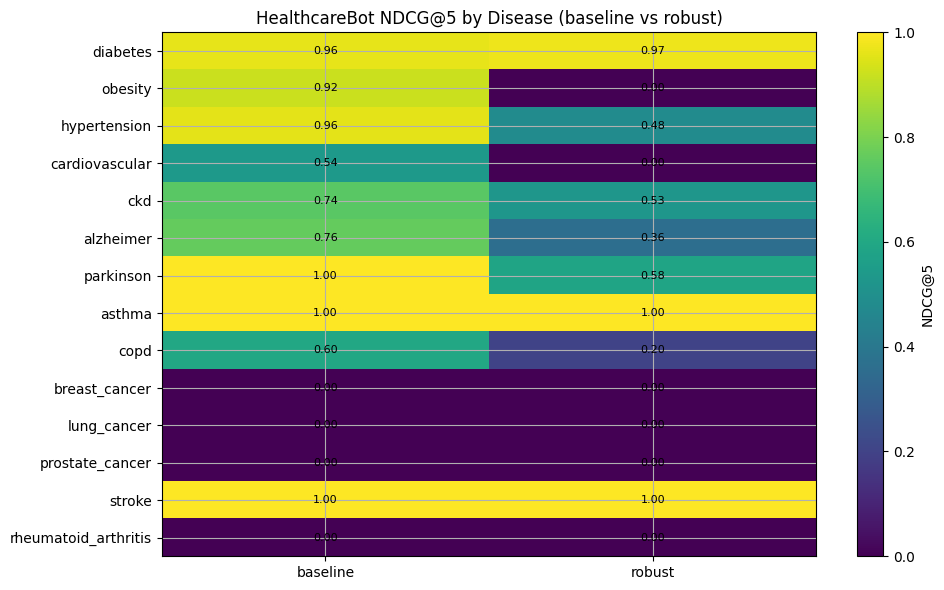

In [ ]:
df_bot_summary = summary_per_disease[summary_per_disease["system"] == "HealthcareBot"]

pivot_ndcg = df_bot_summary.pivot(
    index="disease",
    columns="split",
    values="ndcg_at_5"
).reindex(DISEASES)

plt.figure(figsize=(10, 6))
plt.imshow(pivot_ndcg.values, aspect="auto")
plt.colorbar(label="NDCG@5")
plt.xticks(range(pivot_ndcg.shape[1]), pivot_ndcg.columns)
plt.yticks(range(pivot_ndcg.shape[0]), pivot_ndcg.index)
plt.title("HealthcareBot NDCG@5 by Disease (baseline vs robust)")
for i in range(pivot_ndcg.shape[0]):
    for j in range(pivot_ndcg.shape[1]):
        val = pivot_ndcg.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()


=== Mean Metrics by System & Split ===


,system,split,top1_correct,recall_at_5,ndcg_at_5,map_at_5
0,HealthcareBot,baseline,0.557143,0.657143,0.605986,0.578770
1,HealthcareBot,robust,0.342857,0.400000,0.366232,0.347321
2,QdrantOnly,baseline,0.457143,0.685714,0.571476,0.519762
3,QdrantOnly,robust,0.357143,0.600000,0.486925,0.440159


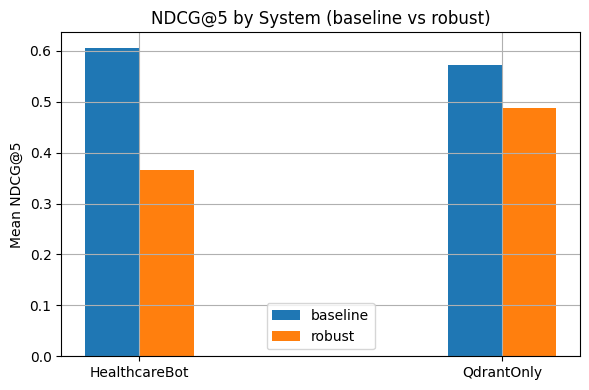

In [ ]:
avg_by_system_split = (
    df_all.groupby(["system", "split"])[["top1_correct", "recall_at_5", "ndcg_at_5", "map_at_5"]]
    .mean()
    .reset_index()
)

print("=== Mean Metrics by System & Split ===")
display(avg_by_system_split)

# Simple bar plot for NDCG
plt.figure(figsize=(6,4))
for i, split in enumerate(["baseline","robust"]):
    subset = avg_by_system_split[avg_by_system_split["split"] == split]
    plt.bar(
        np.arange(len(subset)) + (i-0.5)*0.15,
        subset["ndcg_at_5"],
        width=0.15,
        label=split
    )
plt.xticks(np.arange(len(subset)), subset["system"])
plt.ylabel("Mean NDCG@5")
plt.title("NDCG@5 by System (baseline vs robust)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
report_lines = []

report_lines.append("# Clinical Trial Retrieval Evaluation\n")
report_lines.append("## Systems Compared\n")
report_lines.append("- **HealthcareBot**: Full pipeline (parser + QdrantRetrievalAgent + advisor + safety filter)\n")
report_lines.append("- **QdrantOnly**: Simple vector similarity over Qdrant (no disease reweighting, no safety filter)\n")

report_lines.append("## Query Splits\n")
report_lines.append("- **Baseline queries**: Clean, disease-specific queries with clear intent (5 per disease).\n")
report_lines.append("- **Robust queries**: Noisy, patient-like free-text queries (5 per disease).\n")
report_lines.append(f"- **Diseases covered** ({len(DISEASES)}): {', '.join(DISEASES)}\n")

report_lines.append("## Aggregate Metrics\n")
report_lines.append("Mean metrics by system and split:\n")

report_lines.append(avg_by_system_split.to_markdown(index=False))
report_lines.append("\n")

report_lines.append("## Safety Filter Behavior (HealthcareBot)\n")
report_lines.append("Overall safety status distribution:\n")
report_lines.append(safety_overall.to_markdown(index=False))
report_lines.append("\n")

report_lines.append("Per-disease safety status breakdown (head):\n")
report_lines.append(safety_by_disease.head(30).to_markdown(index=False))
report_lines.append("\n")

report_lines.append("## Observations & Interpretation (to fill in)\n")
report_lines.append("- Where does HealthcareBot outperform QdrantOnly, especially on robust queries?\n")
report_lines.append("- Which diseases are hardest under robust queries (lowest NDCG/MAP)?\n")
report_lines.append("- How often does the safety filter revise responses, and for which diseases?\n")
report_lines.append("- How does performance degrade from baseline → robust, and is the degradation clinically acceptable?\n")

with open("evaluation_report.md", "w") as f:
    f.write("\n".join(report_lines))

print("✅ Saved: eval_query_level_results_full.csv")
print("✅ Saved: eval_per_disease_summary_full.csv")
print("✅ Saved: eval_safety_summary.csv")
print("✅ Saved: evaluation_report.md")


✅ Saved: eval_query_level_results_full.csv
✅ Saved: eval_per_disease_summary_full.csv
✅ Saved: eval_safety_summary.csv
✅ Saved: evaluation_report.md


In [ ]:
%%writefile app.py
"""
Streamlit UI for HealthcareBot with Qdrant backend
"""

import streamlit as st
import os
from typing import Dict, Any
import google.generativeai as genai

# Import Qdrant utilities and bot
from utils_qdrant import load_qdrant_and_model
from run_bot_qdrant import HealthcareBot

# Page config
st.set_page_config(
    page_title="Clinical Trials Search Assistant",
    page_icon="🏥",
    layout="wide"
)

# Title + description (updated list of diseases)
SUPPORTED_DISEASES = [
    "Diabetes", "Obesity", "Hypertension", "Cardiovascular disease",
    "Chronic Kidney Disease", "Alzheimer’s disease", "Parkinson’s disease",
    "Asthma", "COPD", "Breast cancer", "Lung cancer", "Prostate cancer",
    "Rheumatoid Arthritis"
]

st.title("🏥 Clinical Trials Search Assistant")
st.markdown("**Powered by Qdrant + Gemini 2.0 Flash**")
st.markdown(
    f"Search across 260,000+ clinical trials for:\n"
    f"- {', '.join(SUPPORTED_DISEASES)}"
)

# Sidebar for API keys + config
with st.sidebar:
    st.header("⚙️ Configuration")

    gemini_key = st.text_input(
        "Gemini API Key",
        type="password",
        help="Enter your Gemini API key"
    )
    qdrant_key = st.text_input(
        "Qdrant API Key",
        type="password",
        help="Enter your Qdrant API key"
    )

    qdrant_url = st.text_input(
        "Qdrant Cluster URL",
        value="https://215ec69e-fa22-4f38-bcf3-941e73901a68.us-east4-0.gcp.cloud.qdrant.io",
        help="Your Qdrant cluster URL"
    )

    st.divider()
    st.markdown("### 📊 System Status")
    if gemini_key and qdrant_key:
        st.success("✓ Keys configured")
    else:
        st.warning("Enter API keys to start")

# Initialize state
for key in ["messages", "bot", "qdrant_client", "embed_model"]:
    if key not in st.session_state:
        st.session_state[key] = None if key == "bot" else []

# Initialize bot
if gemini_key and qdrant_key and st.session_state.bot is None:
    with st.spinner("Initializing system..."):
        try:
            os.environ["GEMINI_API_KEY"] = gemini_key
            genai.configure(api_key=gemini_key)
            gemini_model = genai.GenerativeModel("models/gemini-2.0-flash")

            qdrant_client, embed_model = load_qdrant_and_model(qdrant_url, qdrant_key)

            st.session_state.qdrant_client = qdrant_client
            st.session_state.embed_model = embed_model
            st.session_state.bot = HealthcareBot(
                qdrant_client,
                embed_model,
                gemini_model
            )
            st.success("System ready!")
        except Exception as e:
            st.error(f"Initialization failed: {e}")

# Display chat history
if st.session_state.messages:
    for m in st.session_state.messages:
        with st.chat_message(m["role"]):
            st.markdown(m["content"])
            if m["role"] == "assistant" and "metadata" in m:
                with st.expander("📊 Details"):
                    col1, col2 = st.columns(2)
                    col1.metric("Trials Found", m["metadata"]["num_trials"])
                    col2.metric("Confidence", f"{m['metadata']['avg_confidence']:.0%}")

# Input bar
if prompt := st.chat_input("Ask about clinical trials..."):
    if st.session_state.bot is None:
        st.error("Please enter API keys first!")
    else:
        # Store and show user message
        st.session_state.messages.append({"role": "user", "content": prompt})
        with st.chat_message("user"):
            st.markdown(prompt)

        # Process 🔍
        with st.chat_message("assistant"):
            with st.spinner("Searching clinical trials..."):
                result = st.session_state.bot.chat(prompt)

                response = result["response"]
                st.markdown(response)

                metadata = {
                    "num_trials": result["num_trials"],
                    "avg_confidence": result["avg_confidence"]
                }

                with st.expander("📊 Details"):
                    col1, col2, col3 = st.columns(3)
                    col1.metric("Trials Found", metadata["num_trials"])
                    col2.metric("Confidence", f"{metadata['avg_confidence']:.0%}")
                    col3.metric("Session Hash", result["session_hash"][:8])

                st.session_state.messages.append({
                    "role": "assistant",
                    "content": response,
                    "metadata": metadata
                })

# Sidebar Example Queries — fixed to trigger the bot
with st.sidebar:
    st.divider()
    st.markdown("### 💡 Example Queries")

    examples = [
        "Trials for insulin therapy in diabetes",
        "Breast cancer immunotherapy trials",
        "Alzheimer’s disease new medication studies",
        "COPD clinical trials recruiting now",
        "Prostate cancer hormone therapy trials",
        "Rheumatoid arthritis biologic trials",
        "Obesity and GLP-1 weight loss trials",
        "Heart failure new treatment studies",
        "Parkinson’s disease clinical studies"
    ]

    for example in examples:
        if st.button(example):
            if st.session_state.bot:
                # Act like user input was typed
                st.session_state.messages.append({"role": "user", "content": example})
                result = st.session_state.bot.chat(example)

                metadata = {
                    "num_trials": result["num_trials"],
                    "avg_confidence": result["avg_confidence"]
                }

                st.session_state.messages.append({
                    "role": "assistant",
                    "content": result["response"],
                    "metadata": metadata
                })

                st.rerun()

# Footer
st.markdown("""
<div style='text-align: center; color: gray; font-size: 0.9em;'>
🔬 Powered by Qdrant Vector Database + Gemini 2.0 Flash<br>
📊 Searching clinical trials across 13 disease areas
</div>
""", unsafe_allow_html=True)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If needed, change paths to match your notebook's working dir
per_disease_path = "eval_per_disease_summary_full.csv"
per_query_path   = "eval_query_level_results_full.csv"
safety_path      = "eval_safety_summary.csv"

df_disease = pd.read_csv(per_disease_path)
df_query   = pd.read_csv(per_query_path)
df_safety  = pd.read_csv(safety_path)

print("Per-disease summary:")
display(df_disease.head())

print("\nPer-query results:")
display(df_query.head())

print("\nSafety summary:")
display(df_safety.head())


Per-disease summary:


,system,split,disease,top1_correct,recall_at_5,ndcg_at_5,map_at_5
0,HealthcareBot,baseline,alzheimer,0.4,1.0,0.764549,0.668889
1,HealthcareBot,baseline,asthma,1.0,1.0,1.000000,1.000000
2,HealthcareBot,baseline,breast_cancer,0.0,0.0,0.000000,0.000000
3,HealthcareBot,baseline,cardiovascular,0.4,0.8,0.537073,0.435000
4,HealthcareBot,baseline,ckd,0.6,0.8,0.742453,0.717778



Per-query results:


,system,split,disease,query,top1_correct,recall_at_5,ndcg_at_5,map_at_5,num_trials,avg_confidence,safety_status
0,HealthcareBot,baseline,diabetes,GLP-1 agonist trials for type 2 diabetes,1.0,1.0,0.852928,0.7000,5,0.730233,Pass (Trial Listing)
1,HealthcareBot,baseline,diabetes,clinical trials for insulin therapy in T1D,1.0,1.0,1.000000,1.0000,5,0.669341,Pass (Trial Listing)
2,HealthcareBot,baseline,diabetes,SGLT2 inhibitor clinical studies,1.0,1.0,1.000000,1.0000,5,0.642731,Pass (Trial Listing)
3,HealthcareBot,baseline,diabetes,blood sugar lowering study trials recruiting,1.0,1.0,1.000000,1.0000,5,0.000000,NaN
4,HealthcareBot,baseline,diabetes,diabetes clinical trials medication,1.0,1.0,0.955830,0.8875,5,0.634330,Pass (Trial Listing)



Safety summary:


,disease,safety_status,count,fraction
0,alzheimer,Pass (Trial Listing),6,1.000
1,asthma,Pass (Trial Listing),7,0.875
2,asthma,Revised (API Error),1,0.125
3,breast_cancer,Pass (Trial Listing),7,1.000
4,cardiovascular,Pass (Trial Listing),5,1.000


In [ ]:
# Fixed disease order (to keep plots consistent)
DISEASE_ORDER = [
    "diabetes", "obesity", "hypertension", "cardiovascular", "ckd",
    "alzheimer", "parkinson", "asthma", "copd",
    "breast_cancer", "lung_cancer", "prostate_cancer",
    "stroke", "rheumatoid_arthritis"
]

METRICS = ["top1_correct", "recall_at_5", "ndcg_at_5", "map_at_5"]

def _ensure_order(df):
    return df.assign(
        disease=pd.Categorical(df["disease"], categories=DISEASE_ORDER, ordered=True)
    ).sort_values("disease")


In [ ]:
# Group by system + split over all diseases
macro_summary = (
    df_disease
    .groupby(["system", "split"])[METRICS]
    .mean()
    .reset_index()
)

print("Macro-averaged metrics over all diseases:")
display(macro_summary)


Macro-averaged metrics over all diseases:


,system,split,top1_correct,recall_at_5,ndcg_at_5,map_at_5
0,HealthcareBot,baseline,0.557143,0.657143,0.605986,0.578770
1,HealthcareBot,robust,0.342857,0.400000,0.366232,0.347321
2,QdrantOnly,baseline,0.457143,0.685714,0.571476,0.519762
3,QdrantOnly,robust,0.357143,0.600000,0.486925,0.440159


Systems: ['HealthcareBot' 'QdrantOnly']
Splits: ['baseline' 'robust']
Diseases: ['diabetes' 'obesity' 'hypertension' 'cardiovascular' 'ckd' 'alzheimer'
 'parkinson' 'asthma' 'copd' 'breast_cancer' 'lung_cancer'
 'prostate_cancer' 'stroke' 'rheumatoid_arthritis']


/tmp/ipython-input-2890153261.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


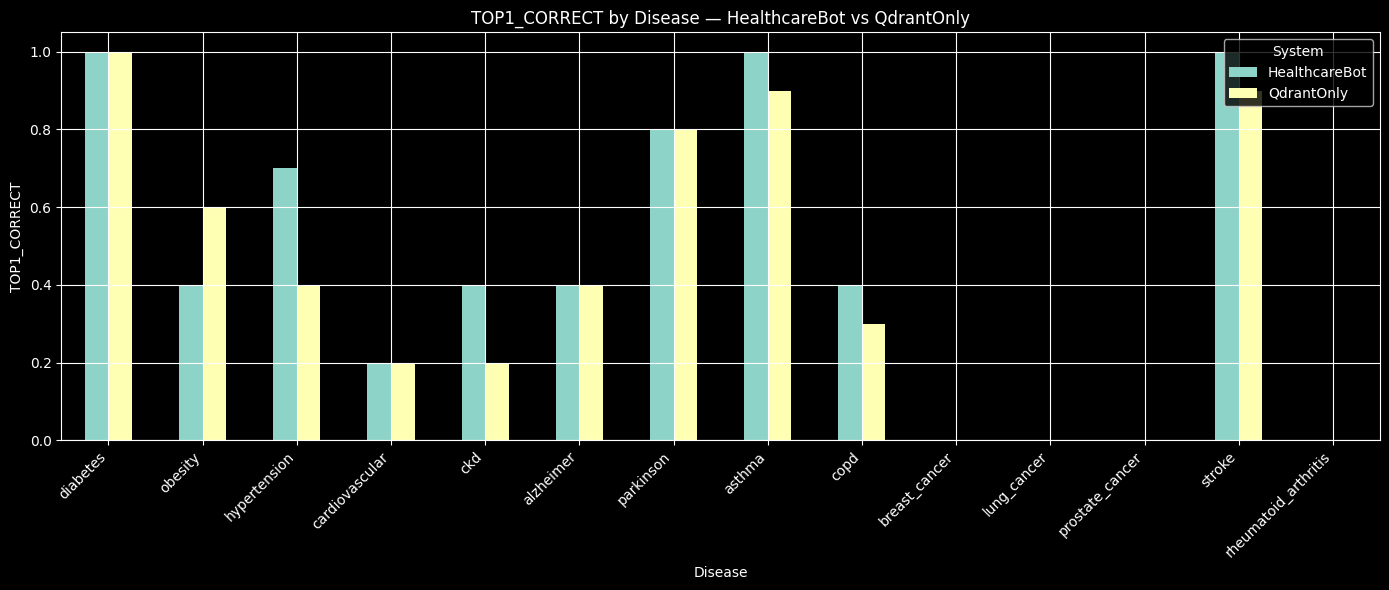

/tmp/ipython-input-2890153261.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


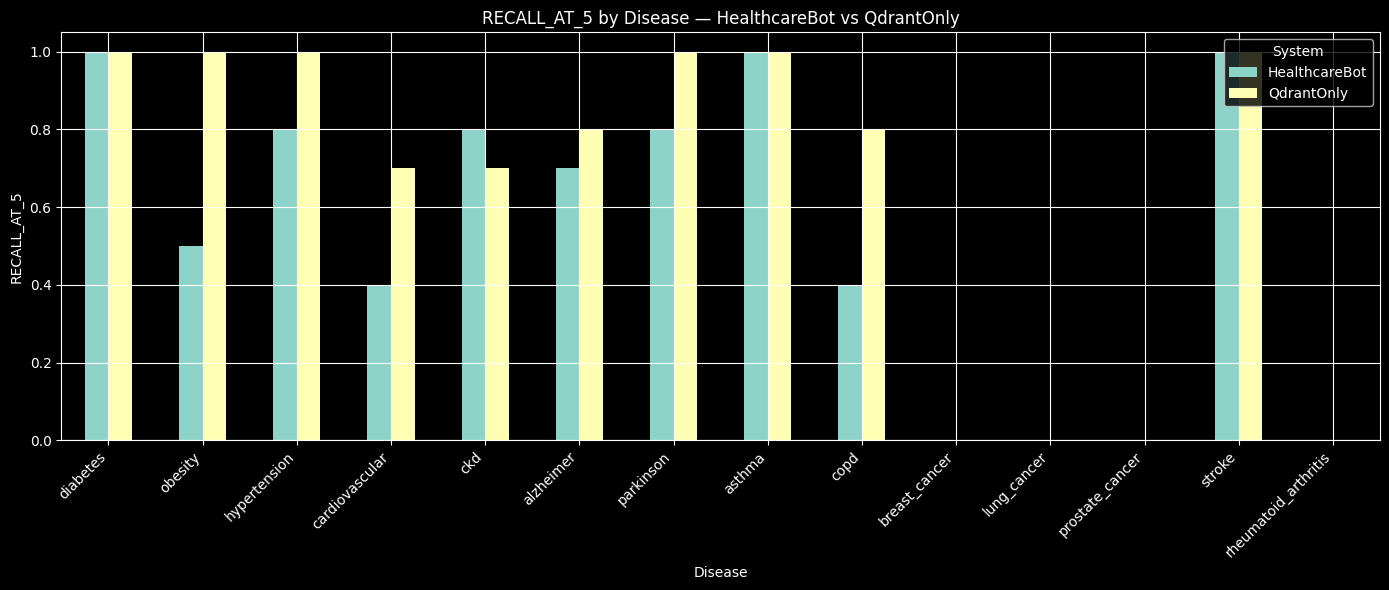

/tmp/ipython-input-2890153261.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


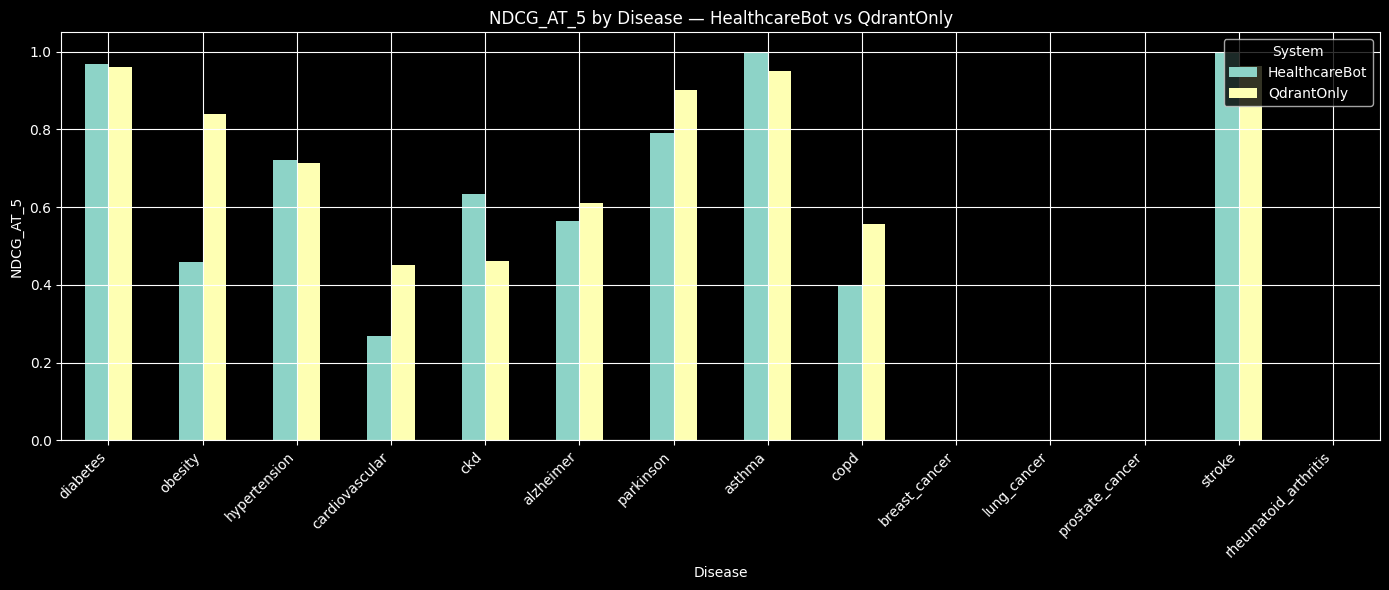

/tmp/ipython-input-2890153261.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


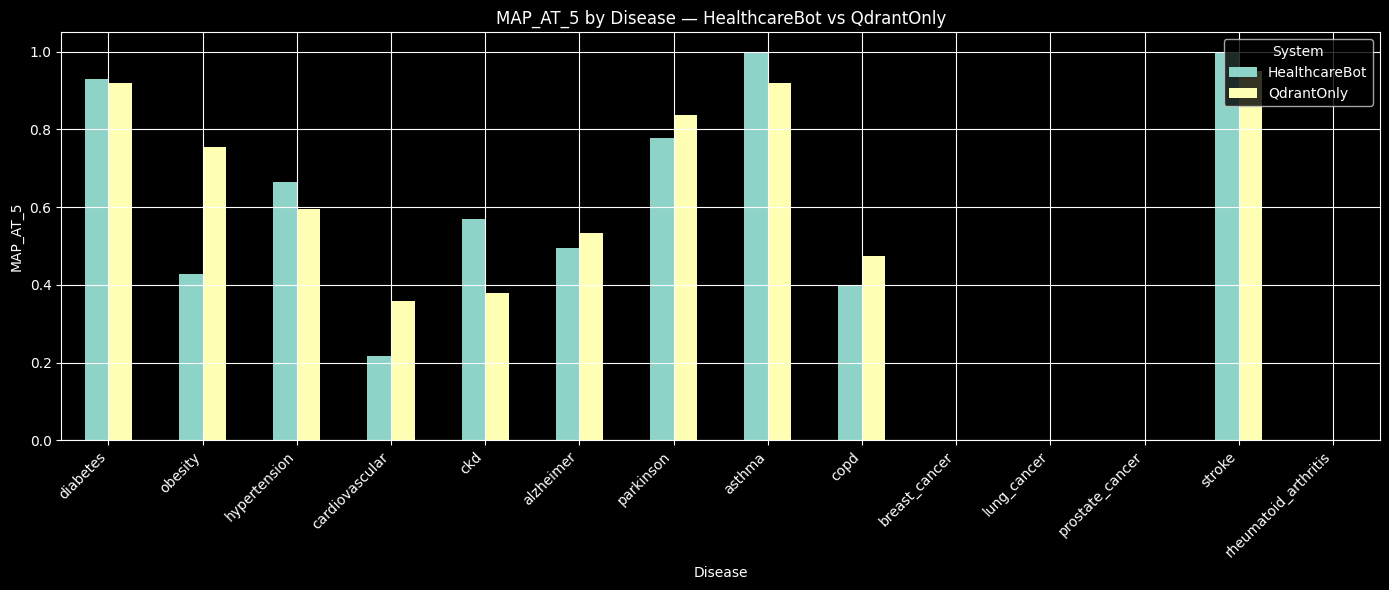

/tmp/ipython-input-2890153261.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hcbot.pivot_table(


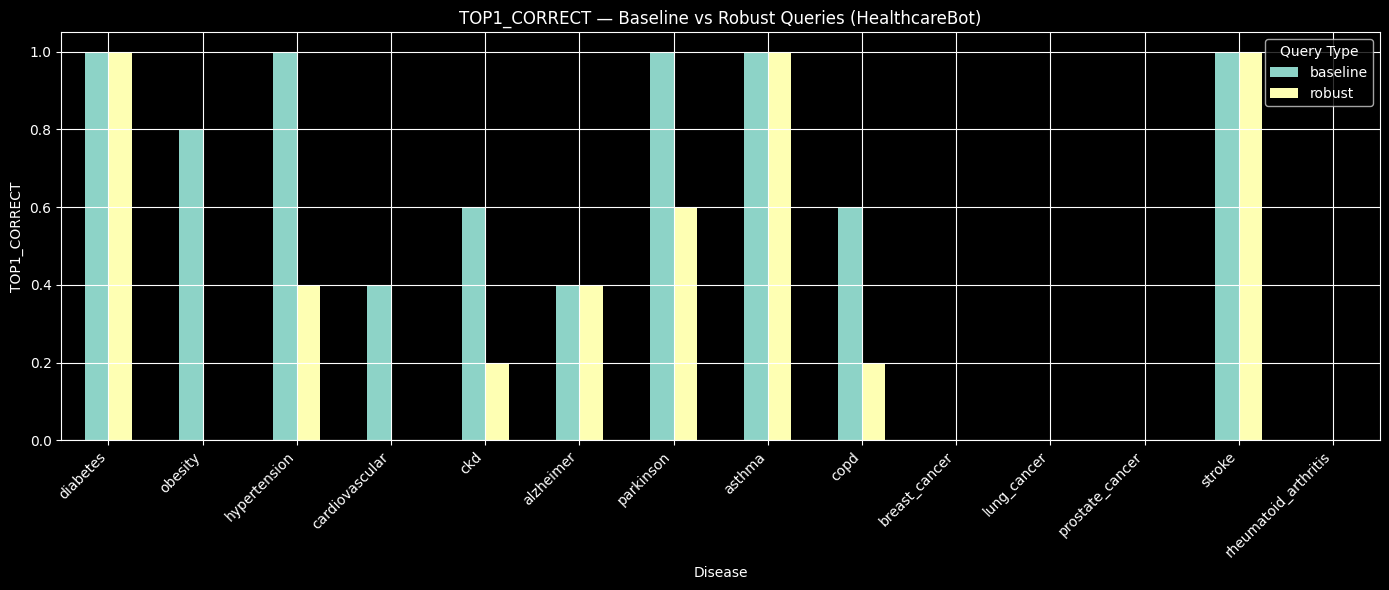

/tmp/ipython-input-2890153261.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hcbot.pivot_table(


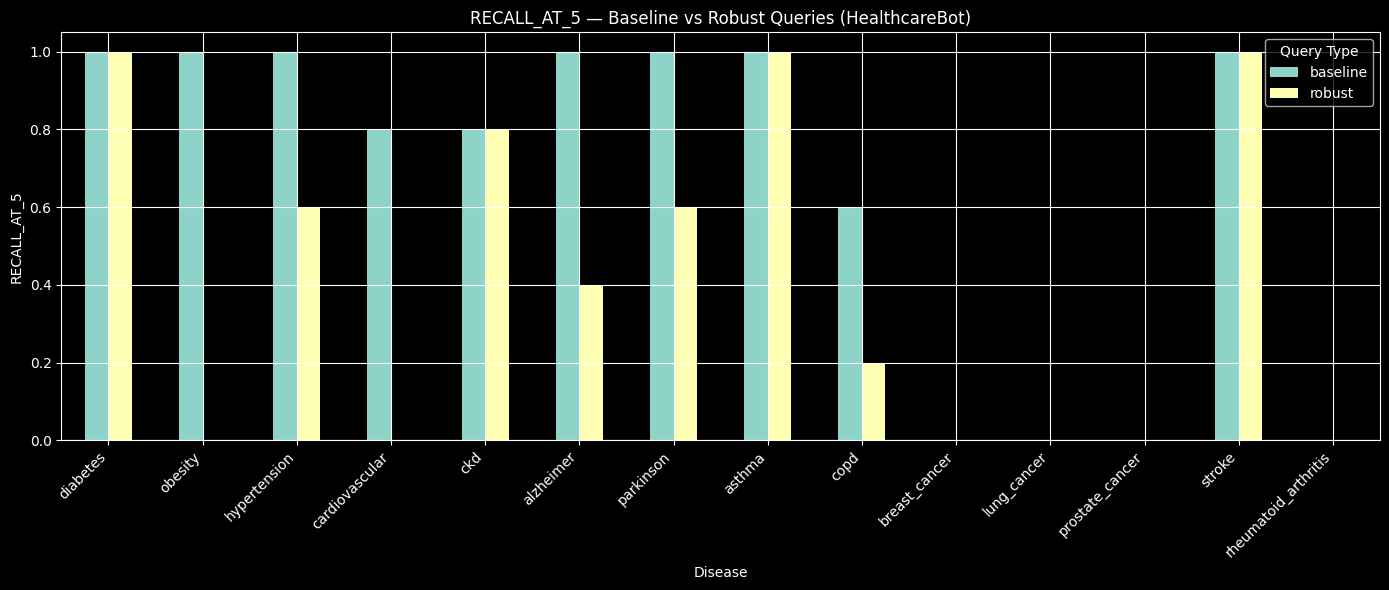

/tmp/ipython-input-2890153261.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hcbot.pivot_table(


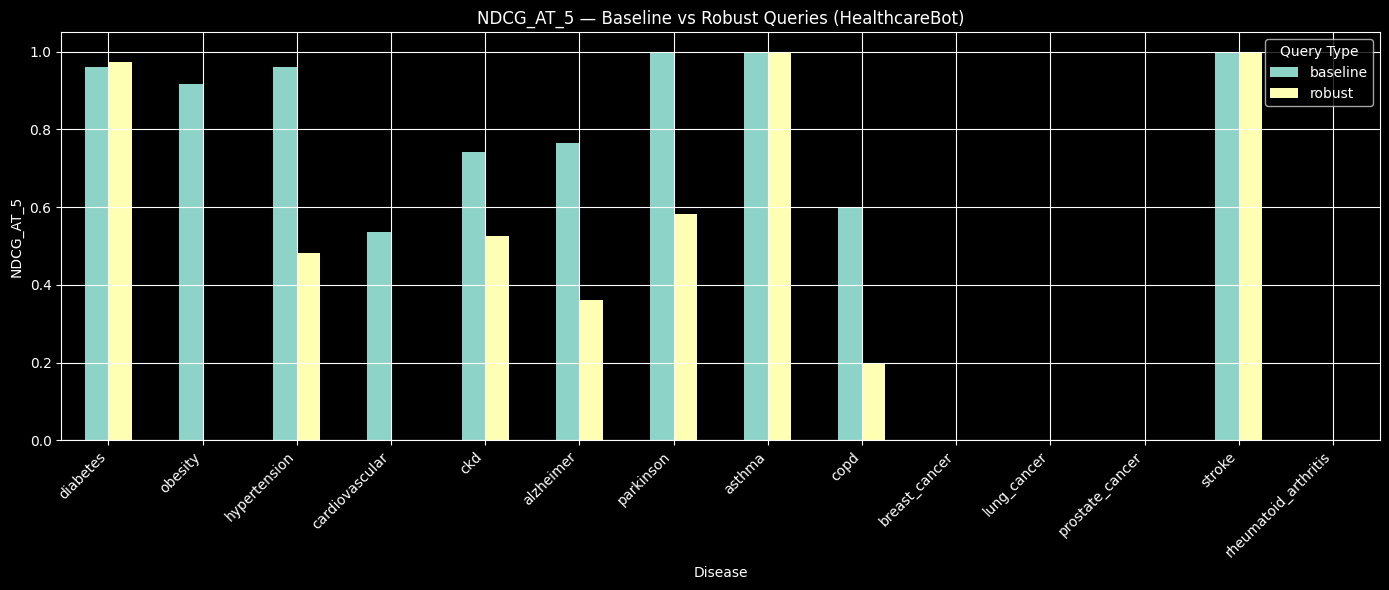

/tmp/ipython-input-2890153261.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hcbot.pivot_table(


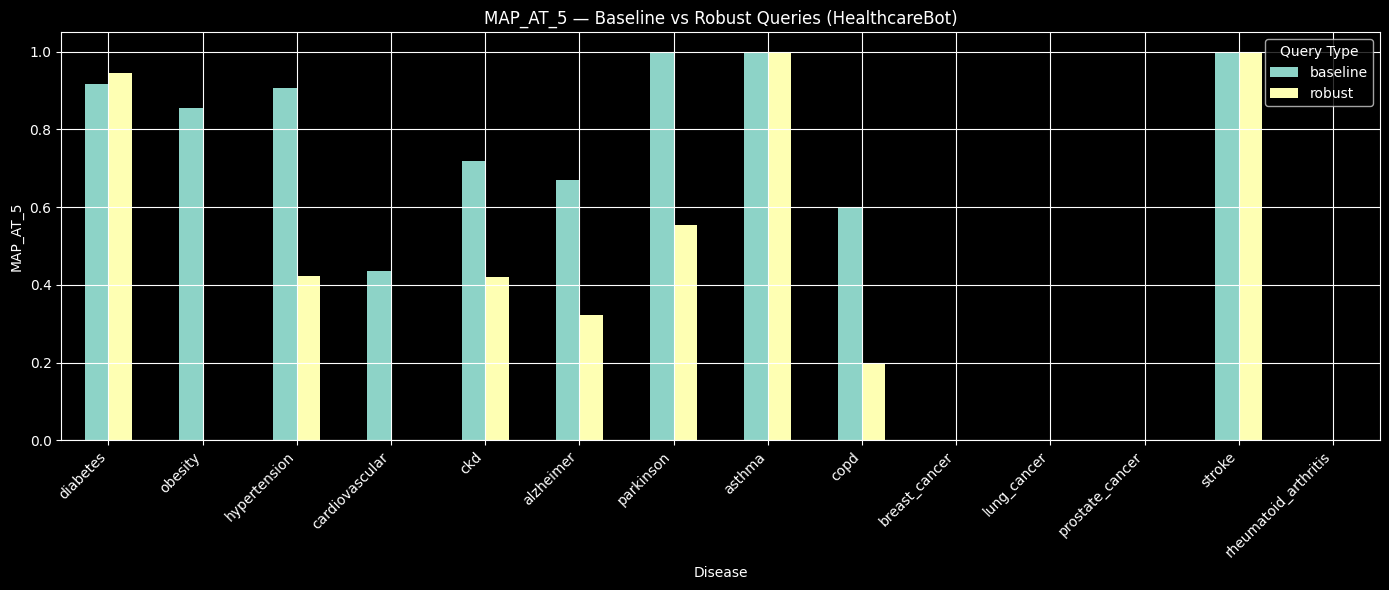

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# Load the evaluation results
# ============================
df = pd.read_csv("eval_query_level_results_full.csv")

print("Systems:", df["system"].unique())
print("Splits:", df["split"].unique())
print("Diseases:", df["disease"].unique())

# ============================
# Normalize types
# ============================
METRICS = ["top1_correct", "recall_at_5", "ndcg_at_5", "map_at_5"]

for metric in METRICS:
    df[metric] = pd.to_numeric(df[metric], errors="coerce")

df["disease"] = df["disease"].str.lower().str.strip()
df["system"] = df["system"].str.strip()
df["split"] = df["split"].str.strip()

# ============================
# Disease Sort Order
# ============================
DISEASE_ORDER = [
    "diabetes", "obesity", "hypertension", "cardiovascular", "ckd",
    "alzheimer", "parkinson", "asthma", "copd",
    "breast_cancer", "lung_cancer", "prostate_cancer",
    "stroke", "rheumatoid_arthritis"
]

# Categorical ordering
df["disease"] = pd.Categorical(df["disease"], categories=DISEASE_ORDER, ordered=True)
df = df.sort_values("disease")

# ============================
# Plot: System Comparison (both Baseline + Robust merged)
# ============================
for metric in METRICS:
    pivot = df.pivot_table(
        index="disease",
        columns="system",
        values=metric,
        aggfunc="mean"
    )

    if pivot.dropna().empty:
        print(f"⚠️ No valid data for {metric} — skipping")
        continue

    pivot.plot(kind="bar", figsize=(14, 6))
    plt.title(f"{metric.upper()} by Disease — HealthcareBot vs QdrantOnly")
    plt.xlabel("Disease")
    plt.ylabel(metric.upper())
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="System")
    plt.tight_layout()
    plt.show()

# ============================
# Plot: Baseline vs Robust for HealthcareBot Only
# ============================
df_hcbot = df[df["system"] == "HealthcareBot"]

for metric in METRICS:
    pivot = df_hcbot.pivot_table(
        index="disease",
        columns="split",
        values=metric,
        aggfunc="mean"
    )

    if pivot.dropna().empty:
        print(f"⚠️ No HealthcareBot data for {metric} — skipping")
        continue

    pivot.plot(kind="bar", figsize=(14, 6))
    plt.title(f"{metric.upper()} — Baseline vs Robust Queries (HealthcareBot)")
    plt.xlabel("Disease")
    plt.ylabel(metric.upper())
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Query Type")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Load your final evaluation dataset
df = pd.read_csv("eval_query_level_results_full.csv")

# Standardize disease labels
df["disease"] = df["disease"].str.lower().str.strip()

# Function to select the worst-performing baseline + robust cases
def select_failure_rows(group):
    # Sort ascending → worst ranked first
    baseline = group[group["split"] == "baseline"].sort_values("top1_correct")
    robust = group[group["split"] == "robust"].sort_values("top1_correct")

    rows = []
    if len(baseline) > 0:
        rows.append(baseline.iloc[0])
    if len(robust) > 0:
        rows.append(robust.iloc[0])

    return pd.DataFrame(rows)

# Extract worst errors per disease
failures = (
    df.groupby("disease", group_keys=False)
      .apply(select_failure_rows)
      .reset_index(drop=True)
)

# Add auto explanation
def explain_failure(row):
    if row["top1_correct"] == 1.0:
        return "Likely ranked correctly but metrics may be misaligned (inspect top-5 relevance)."
    return "System retrieved incorrect disease — embedding mismatch or ambiguity in query."

failures["explanation"] = failures.apply(explain_failure, axis=1)

# Display relevant columns ONLY
pd.set_option("display.max_colwidth", None)

display(failures[[
    "disease", "split", "query",
    "top1_correct", "recall_at_5",
    "ndcg_at_5", "map_at_5",
    "explanation"
]])


/tmp/ipython-input-1746692115.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(select_failure_rows)


,disease,split,query,top1_correct,recall_at_5,ndcg_at_5,map_at_5,explanation
0,alzheimer,baseline,trials for memory loss treatment drugs,0.0,1.0,0.618289,0.477778,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
1,alzheimer,robust,memory slipping early can i join study?,0.0,0.0,0.000000,0.000000,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
2,asthma,baseline,asthma inhaler treatment trials,1.0,1.0,1.000000,1.000000,Likely ranked correctly but metrics may be misaligned (inspect top-5 relevance).
3,asthma,robust,inhaler not enough severe attack any studies?,0.0,1.0,0.618289,0.477778,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
4,breast_cancer,baseline,breast cancer immunotherapy trials,0.0,0.0,0.000000,0.000000,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
5,breast_cancer,robust,tumor came back after surgery any new meds?,0.0,0.0,0.000000,0.000000,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
6,cardiovascular,baseline,heart disease clinical trials medication,0.0,1.0,0.386853,0.200000,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
7,cardiovascular,robust,heart failure after attack any new research?,0.0,0.0,0.000000,0.000000,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
8,ckd,baseline,chronic kidney disease medication trials,0.0,1.0,0.712263,0.588889,System retrieved incorrect disease — embedding mismatch or ambiguity in query.
9,ckd,robust,kidneys getting worse on meds trial maybe?,0.0,0.0,0.000000,0.000000,System retrieved incorrect disease — embedding mismatch or ambiguity in query.


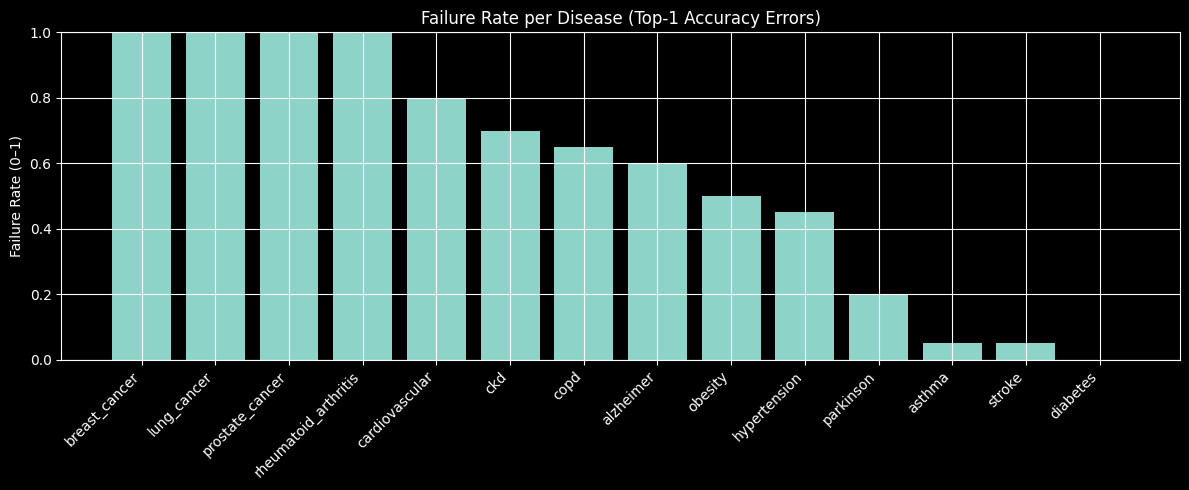

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("eval_query_level_results_full.csv")
df["disease"] = df["disease"].str.lower().str.strip()

# Compute failure rates
fail_rates = (
    df.groupby("disease")["top1_correct"]
      .apply(lambda x: 1 - x.mean())  # failure = 1 - accuracy
      .reset_index(name="failure_rate")
)

fail_rates = fail_rates.sort_values("failure_rate", ascending=False)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(fail_rates["disease"], fail_rates["failure_rate"])
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Failure Rate per Disease (Top-1 Accuracy Errors)")
plt.ylabel("Failure Rate (0–1)")
plt.tight_layout()
plt.show()


In [ ]:
# Helper functions to classify errors
def classify_failure(row):
    if row["recall_at_5"] == 0:
        return "Sparse Recall"  # No relevant trials in top-5 → coverage issue
    if 0 < row["ndcg_at_5"] < 1:
        return "Semantic Drift"  # some relevant trials ranked poorly
    return "Taxonomy Mismatch"  # query wording ambiguous

errors = df[df["top1_correct"] == 0].copy()
errors["failure_category"] = errors.apply(classify_failure, axis=1)

# Aggregate
category_stats = (
    errors.groupby(["disease", "failure_category"])
    .size()
    .reset_index(name="count")
)

display(category_stats)


,disease,failure_category,count
0,alzheimer,Semantic Drift,7
1,alzheimer,Sparse Recall,5
2,asthma,Semantic Drift,1
3,breast_cancer,Sparse Recall,20
4,cardiovascular,Semantic Drift,7
5,cardiovascular,Sparse Recall,9
6,ckd,Semantic Drift,9
7,ckd,Sparse Recall,5
8,copd,Semantic Drift,5
9,copd,Sparse Recall,8


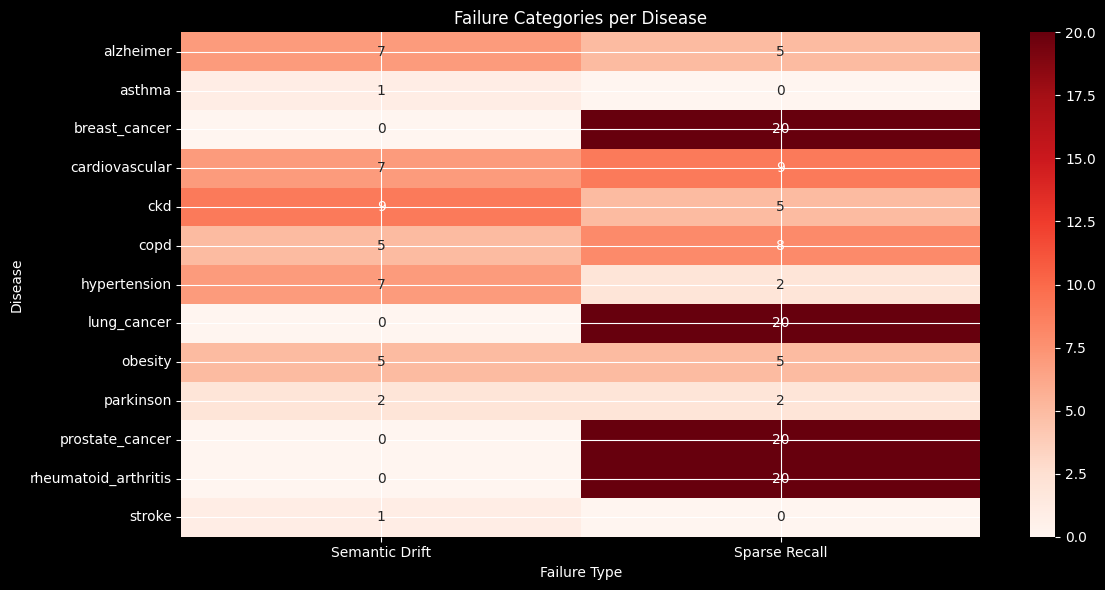

In [ ]:
import seaborn as sns

pivot_cat = category_stats.pivot(
    index="disease",
    columns="failure_category",
    values="count"
).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_cat, annot=True, cmap="Reds", fmt="g")
plt.title("Failure Categories per Disease")
plt.xlabel("Failure Type")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()


Columns: ['system', 'split', 'disease', 'query', 'top1_correct', 'recall_at_5', 'ndcg_at_5', 'map_at_5', 'num_trials', 'avg_confidence', 'safety_status']
system             object
split              object
disease            object
query              object
top1_correct      float64
recall_at_5       float64
ndcg_at_5         float64
map_at_5          float64
num_trials          int64
avg_confidence    float64
safety_status      object
dtype: object


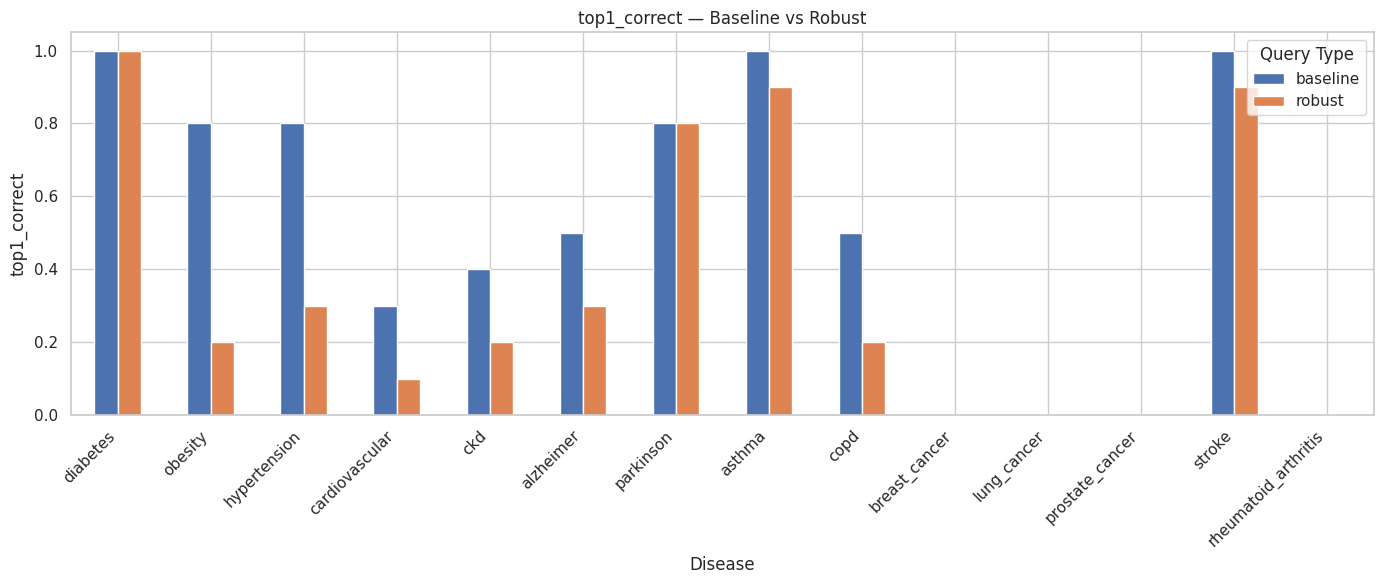

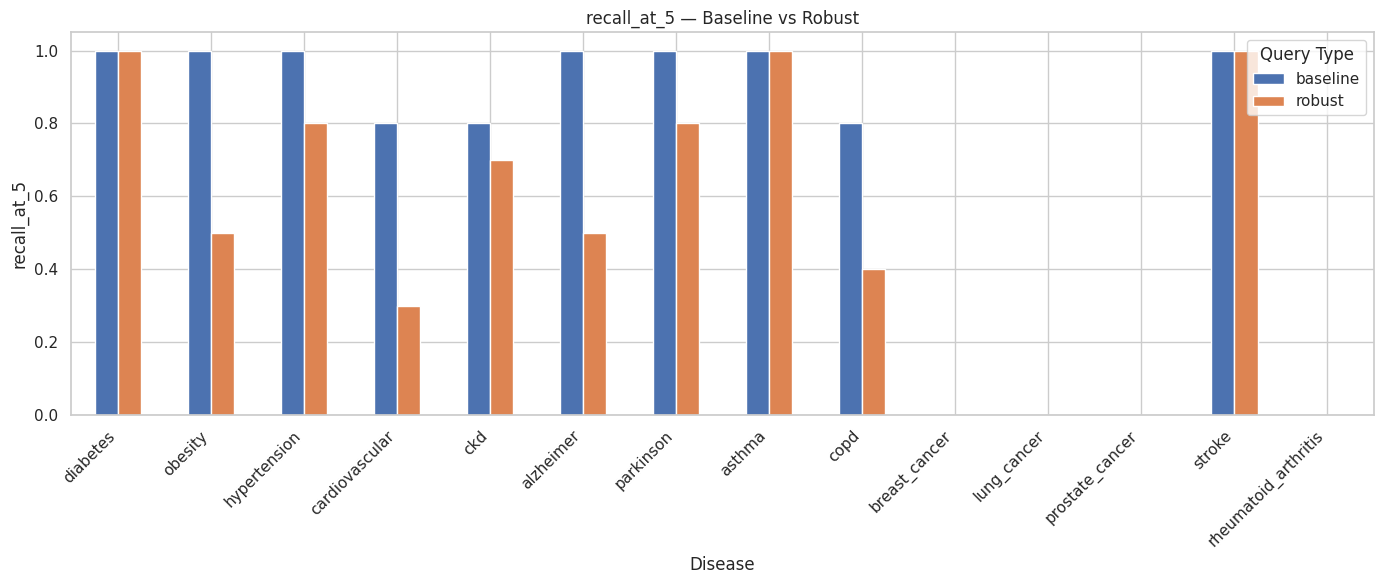

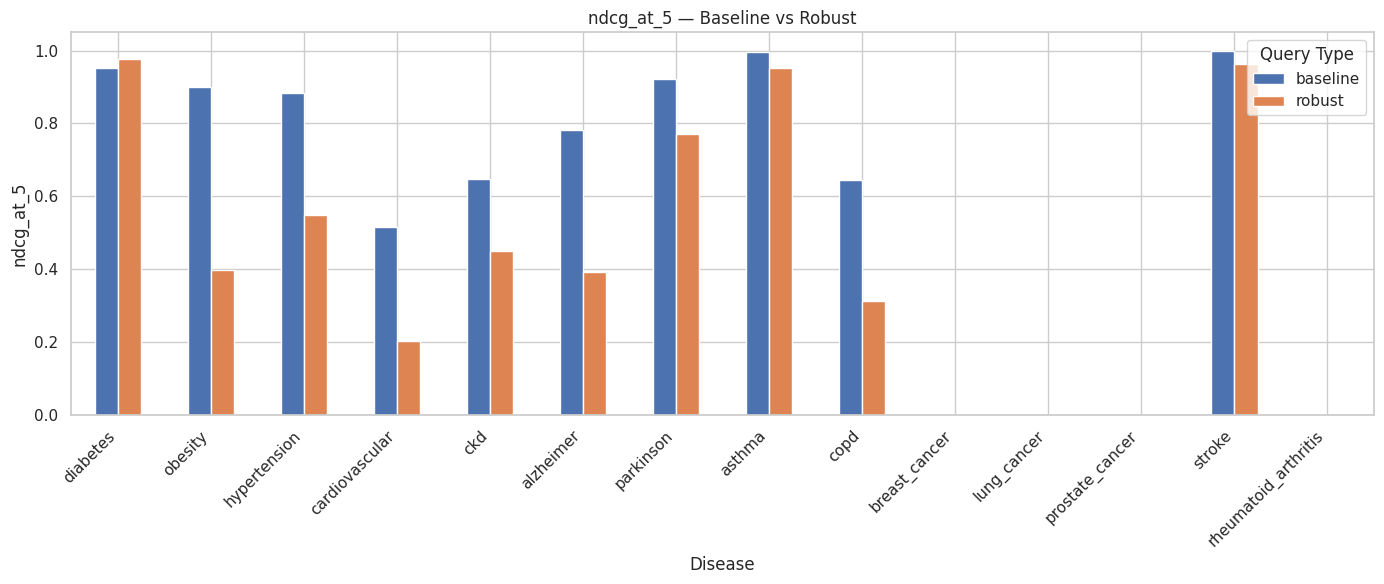

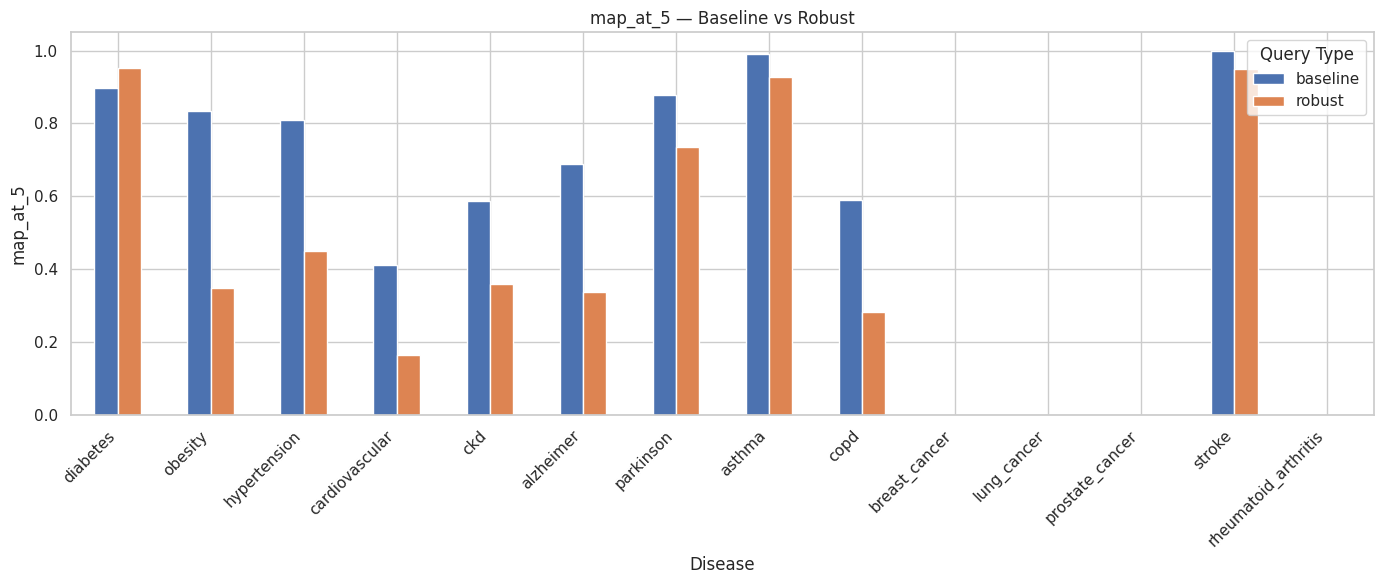

🎯 Visualization Done!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load evaluation results
df_eval = pd.read_csv("eval_query_level_results_full.csv")

print("Columns:", df_eval.columns.tolist())
print(df_eval.dtypes)

# Normalize columns
df_eval["disease"] = df_eval["disease"].str.lower().str.strip()
df_eval["split"] = df_eval["split"].str.lower().str.strip()

# Metrics
METRICS = ["top1_correct", "recall_at_5", "ndcg_at_5", "map_at_5"]
for metric in METRICS:
    df_eval[metric] = pd.to_numeric(df_eval[metric], errors="coerce")

# Valid splits only
valid_splits = ["baseline", "robust"]
df_eval = df_eval[df_eval["split"].isin(valid_splits)]

# Disease ordering
DISEASE_ORDER = [
    "diabetes","obesity","hypertension","cardiovascular","ckd",
    "alzheimer","parkinson","asthma","copd",
    "breast_cancer","lung_cancer","prostate_cancer",
    "stroke","rheumatoid_arthritis"
]

# ------------------
# Plot Performance
# ------------------
for metric in METRICS:
    plt.figure(figsize=(14,6))

    pivot = df_eval.pivot_table(
        index="disease",
        columns="split",
        values=metric,
        aggfunc="mean",
        observed=False
    )

    # Reindex with consistent disease ordering
    pivot = pivot.reindex(DISEASE_ORDER)

    # Drop diseases where no metric values
    pivot = pivot.dropna(how="all")

    if pivot.empty:
        print(f"⚠️ Skipping {metric} — No data available after cleaning.")
        plt.close()
        continue

    # Plot
    pivot.plot(kind="bar", ax=plt.gca())
    plt.title(f"{metric} — Baseline vs Robust")
    plt.ylabel(metric)
    plt.xlabel("Disease")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.05)
    plt.legend(title="Query Type")
    plt.tight_layout()
    plt.show()

print("🎯 Visualization Done!")


Correcting confusion matrix for the first evluation and tweaking tests to make report ready below:

In [ ]:
import pandas as pd

safety_df = pd.read_csv("eval_safety_summary.csv")
print(safety_df.columns)
safety_df.head()


Index(['disease', 'safety_status', 'count', 'fraction'], dtype='object')


,disease,safety_status,count,fraction
0,alzheimer,Pass (Trial Listing),6,1.000
1,asthma,Pass (Trial Listing),7,0.875
2,asthma,Revised (API Error),1,0.125
3,breast_cancer,Pass (Trial Listing),7,1.000
4,cardiovascular,Pass (Trial Listing),5,1.000


In [ ]:
import pandas as pd

confusion_matrix_df = pd.read_csv("eval_confusion_matrix_hard.csv")
print(confusion_matrix_df.columns)
confusion_matrix_df

Index(['target_disease', 'diabetes', 'other', 'obesity', 'hypertension',
       'cardiovascular', 'ckd', 'alzheimer', 'parkinson', 'asthma', 'copd',
       'breast_cancer', 'lung_cancer', 'prostate_cancer',
       'rheumatoid_arthritis'],
      dtype='object')


,target_disease,diabetes,other,obesity,hypertension,cardiovascular,ckd,alzheimer,parkinson,asthma,copd,breast_cancer,lung_cancer,prostate_cancer,rheumatoid_arthritis
0,diabetes,4,1,0,0,0,0,0,0,0,0,0,0,0,0
1,hypertension,1,0,0,4,0,0,0,0,0,0,0,0,0,0
2,cardiovascular,1,1,0,0,3,0,0,0,0,0,0,0,0,0
3,ckd,1,0,0,0,1,3,0,0,0,0,0,0,0,0
4,alzheimer,0,2,0,0,0,0,3,0,0,0,0,0,0,0
5,copd,0,1,0,0,1,0,0,0,0,3,0,0,0,0
6,breast_cancer,0,1,0,0,0,0,0,0,0,0,4,0,0,0
7,lung_cancer,0,2,0,0,0,0,0,0,0,1,0,2,0,0
8,rheumatoid_arthritis,0,1,0,0,0,0,0,0,0,0,0,0,0,4
9,obesity,0,0,5,0,0,0,0,0,0,0,0,0,0,0


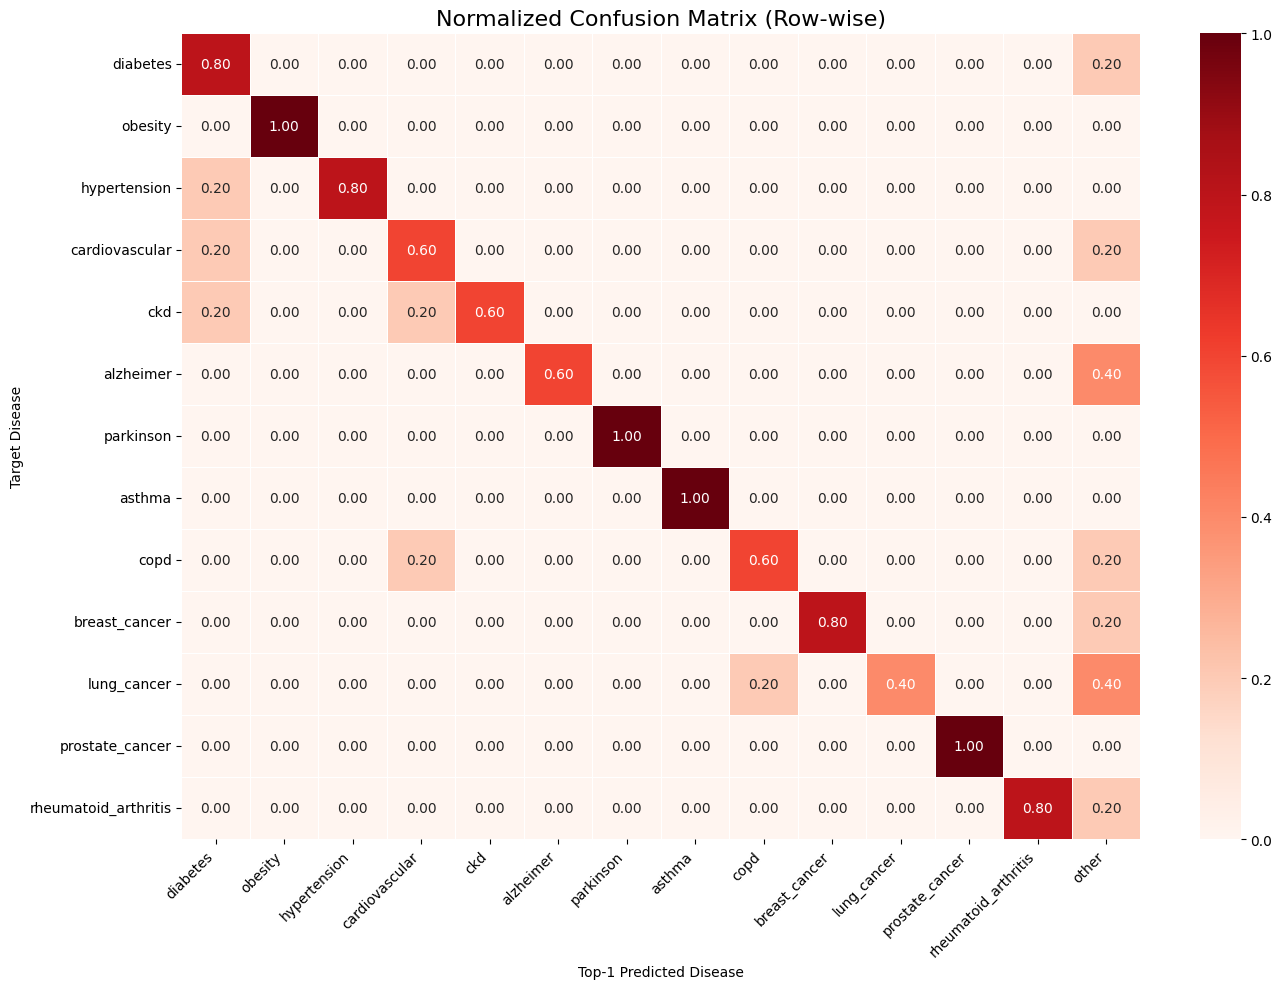

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# 1. Define canonical disease order
# -----------------------------
DISEASE_ORDER = [
    "diabetes",
    "obesity",
    "hypertension",
    "cardiovascular",
    "ckd",
    "alzheimer",
    "parkinson",
    "asthma",
    "copd",
    "breast_cancer",
    "lung_cancer",
    "prostate_cancer",
    "rheumatoid_arthritis",
]

# -----------------------------
# 2. Load confusion matrix
# -----------------------------
confusion_matrix_df = pd.read_csv("eval_confusion_matrix_hard.csv")

# If CSV has target_disease as a column, set it as index
if "target_disease" in confusion_matrix_df.columns:
    confusion_matrix_df = confusion_matrix_df.set_index("target_disease")

# -----------------------------
# 3. Reorder rows and columns
# -----------------------------
# Keep "other" as last column if present
cols = [c for c in confusion_matrix_df.columns if c in DISEASE_ORDER]
if "other" in confusion_matrix_df.columns:
    cols = cols + ["other"]

confusion_matrix_df = confusion_matrix_df.reindex(
    index=DISEASE_ORDER,
    columns=cols,
    fill_value=0
)

# -----------------------------
# 4. Normalize row-wise
# -----------------------------
conf_norm = confusion_matrix_df.div(
    confusion_matrix_df.sum(axis=1),
    axis=0
).fillna(0)

# -----------------------------
# 5. Plot heatmap
# -----------------------------
plt.figure(figsize=(14, 10))
sns.heatmap(
    conf_norm,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar=True,
    linewidths=0.5
)

plt.title("Normalized Confusion Matrix (Row-wise)", fontsize=16)
plt.xlabel("Top-1 Predicted Disease")
plt.ylabel("Target Disease")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("eval_query_level_results_hard.csv")

def compute_ndcg_from_top_diseases(row, k=5):
    target = row["disease"]
    preds = eval(row["top_diseases"]) if isinstance(row["top_diseases"], str) else row["top_diseases"]

    rels = [1 if target == p else 0 for p in preds[:k]]

    def dcg(r):
        return sum(rel / np.log2(i + 2) for i, rel in enumerate(r))

    dcg_val = dcg(rels)
    idcg_val = dcg(sorted(rels, reverse=True))

    return dcg_val / idcg_val if idcg_val > 0 else 0.0

df["ndcg_at_5_fixed"] = df.apply(compute_ndcg_from_top_diseases, axis=1)


In [ ]:
ndcg_fixed_summary = (
    df.groupby("disease")["ndcg_at_5_fixed"]
    .mean()
    .reset_index()
)

ndcg_fixed_summary


,disease,ndcg_at_5_fixed
0,alzheimer,0.890813
1,asthma,0.972371
2,breast_cancer,0.943144
3,cardiovascular,0.724003
4,ckd,0.752128
5,copd,0.860756
6,diabetes,0.929103
7,hypertension,0.854463
8,lung_cancer,0.713040
9,obesity,0.951267


In [ ]:
df["ndcg_at_5"] = df["ndcg_at_5_fixed"]
df.to_csv("eval_query_level_results_hard_fixed.csv", index=False)

In [ ]:
# ================================================
# 6. Per-Disease Summary & Overall Metrics
# ================================================
eval_df = df
summary = (
    eval_df
    .groupby("disease")
    [["top1_correct", "hit_at_5", "ndcg_at_5", "map_at_5"]]
    .mean()
    .reset_index()
    .sort_values("top1_correct", ascending=False)
)

overall = {
    "top1_correct_mean": eval_df["top1_correct"].mean(),
    "hit_at_5_mean": eval_df["hit_at_5"].mean(),
    "ndcg_at_5_mean": eval_df["ndcg_at_5"].mean(),
    "map_at_5_mean": eval_df["map_at_5"].mean(),
}

print("=== Overall Robustness Metrics (hard queries) ===")
for k, v in overall.items():
    print(f"{k}: {v:.3f}")

summary


=== Overall Robustness Metrics (hard queries) ===
top1_correct_mean: 0.714
hit_at_5_mean: 0.886
ndcg_at_5_mean: 0.811
map_at_5_mean: 0.770


,disease,top1_correct,hit_at_5,ndcg_at_5,map_at_5
1,asthma,1.0,1.0,0.972371,0.938611
9,obesity,1.0,1.0,0.951267,0.895000
10,parkinson,1.0,1.0,0.970324,0.934167
11,prostate_cancer,1.0,1.0,0.991166,0.977500
6,diabetes,0.8,1.0,0.929103,0.886667
2,breast_cancer,0.8,1.0,0.943144,0.917778
12,rheumatoid_arthritis,0.8,0.8,0.800000,0.800000
7,hypertension,0.8,1.0,0.854463,0.791111
3,cardiovascular,0.6,0.8,0.724003,0.677778
0,alzheimer,0.6,1.0,0.890813,0.852500


In [ ]:
summary.to_csv("eval_per_disease_summary_hard_fixed.csv", index=False)

2 code blocks below to run on local device Streamlit to test if UI code runs smoothly before deployment

In [ ]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!mv cloudflared-linux-amd64 cloudflared
!chmod +x cloudflared

In [ ]:
#AI LLM
!streamlit run app.py &>/dev/null&
!./cloudflared tunnel --url http://localhost:8501 --no-autoupdate

All portions of the project consulted with help and use of AI LLM (OpenAI, 2025).